Dissertation
    
# **Notebook 8: Training POIs to Ascending LSOAs**
  
This notebook develops models that use POI and NC data to cateogrise and predicict Ascending, or Gentrifying LSOAs.

In [1]:
# Analysis uses package Imblanaced learn, version 0.9.0
# Import and restart the kernel to install 

import sys
!{sys.executable} -m pip install imblearn

In [2]:
# Load packages

import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar

# Models
from sklearn.preprocessing import power_transform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.metrics import geometric_mean_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import ensemble
from sklearn.ensemble import AdaBoostClassifier


In [3]:
# Look at working dir

print("The working directory is " + os.getcwd())

The working directory is /home/jovyan/work/OneDrive/UCL/Dissertation/Notebooks V3


In [4]:
shapefiles = os.path.join("Shapefiles")

profiles = os.path.join("LSOA Profiles")

clean = os.path.join("Cleaned data")

nc = os.path.join("Data", "Now-Casting")

In [5]:
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

In [6]:
def checkpoi(df1, df2):
    if len(df1) == len(df2.columns):
        print("All POI categories are there")
    else:
        x = len(df1) - len(df2.columns) 
        print("There are " + str(x) + " POI categories missing")

In [7]:
def missing(df1, df2):

    collist1 = df1.columns.to_list()
    #collist2 = df2.columns.to_list()
    
    first_set = set(collist1)
    sec_set = set(df2)
# Get the differences between two sets
    differences = (first_set - sec_set).union(sec_set - first_set)
    print('Differences between two lists: ')
    print(differences)

In [8]:
def infodf(dataframe):
    print(f"There are "+str(len(dataframe)) + " rows in the dataframe")
    print(f"There are " + str(dataframe.shape[1]) + " columns in the data frame")
    print(f"The columns of the dataframe are: " + str(dataframe.columns))
    print(f"There are " + str(dataframe.isnull().sum().sum()) + " NaN values in the data frame")
    print(f"These NaN values are located in columns: " + str(dataframe.columns[dataframe.isnull().any()].tolist()))

# 1. Read in Levels

In [9]:
lsoa_2011 = gpd.read_file(os.path.join(shapefiles, "LSOA_KENT_2011.shp"))
outline = gpd.read_file(os.path.join(shapefiles, "KENT_OUTLINE.shp"))

In [10]:
census_asc_df = pd.read_csv(os.path.join(clean, "allclusters.csv"))
census_gent_df = pd.read_csv(os.path.join(clean, "allclusters.csv"))
nc_asc_df = pd.read_csv(os.path.join(clean, "Level1_nc.csv"))
nc_asc_df = nc_asc_df.rename(columns={"LSOA11CD_nc":"LSOA11CD"})

In [11]:
# Create target

census_gent_df["gent"] = "NON-GEN"

for i in range(len(census_gent_df)):
    if census_gent_df.loc[i, "Level2Cat"]=="cluster3":
        census_gent_df.loc[i, "gent"]="GEN"
        
census_asc_df["asc"] = "NON-ASC"

for i in range(len(census_asc_df)):
    if census_asc_df.loc[i, "Level1Cat"]=="ASC":
        census_asc_df.loc[i, "asc"]="ASC"
        
nc_asc_df["asc"] = "NON-ASC"

for i in range(len(nc_asc_df)):
    if nc_asc_df.loc[i, "Level1Cat_nc"]=="ASC":
        nc_asc_df.loc[i, "asc"]="ASC"

In [12]:
# Set targets
#Gent
filt = ["GEN"]
# Gent status (label)
census_gent_df["target_labels"] = np.where(census_gent_df["gent"].isin(filt), "GEN", "")
census_gent_df["target"] = np.where(census_gent_df["gent"].isin(filt), 1., 0.)

# ASC
filt = ["ASC"]
# Gent status (label)
census_asc_df["target_labels"] = np.where(census_asc_df["asc"].isin(filt), "ASC", "")
census_asc_df["target"] = np.where(census_asc_df["asc"].isin(filt), 1., 0.)

nc_asc_df["target_labels"] = np.where(nc_asc_df["asc"].isin(filt), "ASC", "")
nc_asc_df["target"] = np.where(nc_asc_df["asc"].isin(filt), 1., 0.)

# 2. POI

In [13]:
# Read in 

poi_2014_kent =  gpd.read_file(os.path.join(nc, "poi_2014.gpkg"))
poi_2018_kent =  gpd.read_file(os.path.join(nc, "poi_2018.gpkg"))
poi_2022_kent =  gpd.read_file(os.path.join(nc, "poi_2022.gpkg"))


/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [14]:
x = len(poi_2014_kent)
y = len(poi_2018_kent)
z = len(poi_2022_kent)

from statistics import mean

print((x+y+z)/3)

96716.66666666667


In [15]:
poi_2014_kent["classname"].nunique()

576

In [16]:
# Set same CRS
poi_2014 = poi_2014_kent.to_crs(lsoa_2011.crs.to_string())

# Spatial join to get which points in which LSOA
poi_2014 = gpd.sjoin(lsoa_2011, poi_2014, how="left")

# Groupby LSOA
poi_2014 = poi_2014.rename(columns={"classname":"Level_3"})
poi_2014_grouped = pd.DataFrame(poi_2014.groupby(["LSOA11CD", "Level_3"])["Level_3"].count())
poi_2014_grouped = poi_2014_grouped.rename(columns={"Level_3":"count"})
poi_2014_grouped = poi_2014_grouped.reset_index()

# Pivot
poi_2014_grouped = poi_2014_grouped.pivot(index="LSOA11CD", columns="Level_3", values="count")
poi_2014_grouped = poi_2014_grouped.reset_index()
poi_2014_grouped = pd.merge(poi_2014_grouped, (pd.DataFrame(poi_2014_grouped.groupby(["LSOA11CD"])["LSOA11CD"].count()).rename(columns={"LSOA11CD":"count_poi_2014"}).reset_index()), how="left", on="LSOA11CD")

# Fill nan (where there are no points)
poi_2014_grouped = poi_2014_grouped.fillna(0)

# Calculate sum
poi_2014_grouped["count_poi_2014"] = poi_2014_grouped.iloc[:, 1:-2].sum(axis = 1)

In [17]:
# Set same CRS
poi_2018 = poi_2018_kent.to_crs(lsoa_2011.crs.to_string())

# Spatial join to get which points in which LSOA
poi_2018 = gpd.sjoin(lsoa_2011, poi_2018, how="left")

# Groupby LSOA
poi_2018 = poi_2018.rename(columns={"classname":"Level_3"})
poi_2018_grouped = pd.DataFrame(poi_2018.groupby(["LSOA11CD", "Level_3"])["Level_3"].count())
poi_2018_grouped = poi_2018_grouped.rename(columns={"Level_3":"count"})
poi_2018_grouped = poi_2018_grouped.reset_index()

# Pivot
poi_2018_grouped = poi_2018_grouped.pivot(index="LSOA11CD", columns="Level_3", values="count")
poi_2018_grouped = poi_2018_grouped.reset_index()
poi_2018_grouped = pd.merge(poi_2018_grouped, (pd.DataFrame(poi_2018_grouped.groupby(["LSOA11CD"])["LSOA11CD"].count()).rename(columns={"LSOA11CD":"count_poi_2018"}).reset_index()), how="left", on="LSOA11CD")

# Fill nan (where there are no points)
poi_2018_grouped = poi_2018_grouped.fillna(0)

# Calculate sum
poi_2018_grouped["count_poi_2018"] = poi_2018_grouped.iloc[:, 1:-2].sum(axis = 1)

In [18]:
# Set same CRS
poi_2022 = poi_2022_kent.to_crs(lsoa_2011.crs.to_string())

# Spatial join to get which points in which LSOA
poi_2022 = gpd.sjoin(lsoa_2011, poi_2022, how="left")

# Groupby LSOA
poi_2022 = poi_2022.rename(columns={"classname":"Level_3"})
poi_2022_grouped = pd.DataFrame(poi_2022.groupby(["LSOA11CD", "Level_3"])["Level_3"].count())
poi_2022_grouped = poi_2022_grouped.rename(columns={"Level_3":"count"})
poi_2022_grouped = poi_2022_grouped.reset_index()

# Pivot
poi_2022_grouped = poi_2022_grouped.pivot(index="LSOA11CD", columns="Level_3", values="count")
poi_2022_grouped = poi_2022_grouped.reset_index()
poi_2022_grouped = pd.merge(poi_2022_grouped, (pd.DataFrame(poi_2022_grouped.groupby(["LSOA11CD"])["LSOA11CD"].count()).rename(columns={"LSOA11CD":"count_poi_2022"}).reset_index()), how="left", on="LSOA11CD")

# Fill nan (where there are no points)
poi_2022_grouped = poi_2022_grouped.fillna(0)

# Calculate sum
poi_2022_grouped["count_poi_2022"] = poi_2022_grouped.iloc[:, 1:-2].sum(axis = 1)

In [19]:
# Calculate prop

cols = poi_2014_grouped.columns[1:-1].to_list()
poi_2014_prop = poi_2014_grouped[cols].div(poi_2014_grouped.count_poi_2014, axis=0)

cols = poi_2018_grouped.columns[1:-1].to_list()
poi_2018_prop = poi_2018_grouped[cols].div(poi_2018_grouped.count_poi_2018, axis=0)

cols = poi_2022_grouped.columns[1:-1].to_list()
poi_2022_prop = poi_2022_grouped[cols].div(poi_2022_grouped.count_poi_2022, axis=0)

In [20]:
# Look at difference

missing(poi_2014_prop, poi_2018_prop)

poi_2014_prop = poi_2014_prop.drop(['Chemical Engineers', 'Medical Waste Disposal Services', 'Printing On Garments', 'Butterfly Farms', 'Revenue and Customs Offices', 'Cheque Cashing', 'Pneumatic Engineers', 'Diving Services', 'Blood Transfusion Service', 'Oil and Gas Extraction, Refinery and Product Manufacture', 'Message and Greeting Services', 'Cutlery and Tableware', 'Engines', 'Stepping Stones', 'Hotel Booking Agencies', 'Computer Security', 'Motoring Organisations', 'Model Villages', 'Education Authorities', 'Tobacco Products', 'Dental and Medical Laboratories', 'Parachuting and Bungee Jumping', 'Adult Venues'], axis=1, errors='ignore')
poi_2018_prop = poi_2018_prop.drop(['Chemical Engineers', 'Medical Waste Disposal Services', 'Printing On Garments', 'Butterfly Farms', 'Revenue and Customs Offices', 'Cheque Cashing', 'Pneumatic Engineers', 'Diving Services', 'Blood Transfusion Service', 'Oil and Gas Extraction, Refinery and Product Manufacture', 'Message and Greeting Services', 'Cutlery and Tableware', 'Engines', 'Stepping Stones', 'Hotel Booking Agencies', 'Computer Security', 'Motoring Organisations', 'Model Villages', 'Education Authorities', 'Tobacco Products', 'Dental and Medical Laboratories', 'Parachuting and Bungee Jumping', 'Adult Venues'], axis=1, errors='ignore')
poi_2022_prop = poi_2022_prop.drop(['Chemical Engineers', 'Medical Waste Disposal Services', 'Printing On Garments', 'Butterfly Farms', 'Revenue and Customs Offices', 'Cheque Cashing', 'Pneumatic Engineers', 'Diving Services', 'Blood Transfusion Service', 'Oil and Gas Extraction, Refinery and Product Manufacture', 'Message and Greeting Services', 'Cutlery and Tableware', 'Engines', 'Stepping Stones', 'Hotel Booking Agencies', 'Computer Security', 'Motoring Organisations', 'Model Villages', 'Education Authorities', 'Tobacco Products', 'Dental and Medical Laboratories', 'Parachuting and Bungee Jumping', 'Adult Venues'], axis=1, errors='ignore')

missing(poi_2014_prop, poi_2018_prop)


Differences between two lists: 
{'Printing On Garments', 'Pneumatic Engineers', 'Dental and Medical Laboratories', 'Butterfly Farms', 'Cheque Cashing', 'Message and Greeting Services', 'Tobacco Products', 'Stepping Stones', 'Medical Waste Disposal Services', 'Revenue and Customs Offices', 'Engines', 'Diving Services', 'Adult Venues', 'Chemical Engineers', 'Hotel Booking Agencies', 'Motoring Organisations', 'Cutlery and Tableware', 'Computer Security', 'Model Villages', 'Education Authorities', 'Parachuting and Bungee Jumping', 'Oil and Gas Extraction, Refinery and Product Manufacture', 'Blood Transfusion Service'}
Differences between two lists: 
set()


In [21]:
# Look at difference with 2022

missing(poi_2014_prop, poi_2022_prop)
missing(poi_2018_prop, poi_2022_prop)

poi_2014_prop = poi_2014_prop.drop(['Ore Mining', 'Sheep Dips and Washes', 'Lighting Towers', 'Locks', 'Tents, Marquees and Camping Equipment', 'Laseria, Observatories and Planetaria', 'Tanks (Generic)', 'Hoppers and Silos', 'Refrigeration and Freezing Appliances', 'Travelling Cranes and Gantries', 'Fire Safety Features', 'Conveyors', 'Finger Posts, Guide Posts and Cairns', 'Embassies and Consulates', 'Coal Mining', 'Subways', 'Settling, Balancing and Silt Ponds', 'Chimneys', 'Discos', 'Ponds', 'Aeronautical Features', 'Roadside Telephone Boxes', 'Salmon Ladders', 'Tunnels', 'Climbing Facilities'], axis=1, errors='ignore')
poi_2018_prop = poi_2018_prop.drop(['Ore Mining', 'Sheep Dips and Washes', 'Lighting Towers', 'Locks', 'Tents, Marquees and Camping Equipment', 'Laseria, Observatories and Planetaria', 'Tanks (Generic)', 'Hoppers and Silos', 'Refrigeration and Freezing Appliances', 'Travelling Cranes and Gantries', 'Fire Safety Features', 'Conveyors', 'Finger Posts, Guide Posts and Cairns', 'Embassies and Consulates', 'Coal Mining', 'Subways', 'Settling, Balancing and Silt Ponds', 'Chimneys', 'Discos', 'Ponds', 'Aeronautical Features', 'Roadside Telephone Boxes', 'Salmon Ladders', 'Tunnels', 'Climbing Facilities'], axis=1, errors='ignore')
poi_2022_prop = poi_2022_prop.drop(['Ore Mining', 'Sheep Dips and Washes', 'Lighting Towers', 'Locks', 'Tents, Marquees and Camping Equipment', 'Laseria, Observatories and Planetaria', 'Tanks (Generic)', 'Hoppers and Silos', 'Refrigeration and Freezing Appliances', 'Travelling Cranes and Gantries', 'Fire Safety Features', 'Conveyors', 'Finger Posts, Guide Posts and Cairns', 'Embassies and Consulates', 'Coal Mining', 'Subways', 'Settling, Balancing and Silt Ponds', 'Chimneys', 'Discos', 'Ponds', 'Aeronautical Features', 'Roadside Telephone Boxes', 'Salmon Ladders', 'Tunnels', 'Climbing Facilities'], axis=1, errors='ignore')

missing(poi_2014_prop, poi_2022_prop)
missing(poi_2018_prop, poi_2022_prop)

Differences between two lists: 
{'Laseria, Observatories and Planetaria', 'Hoppers and Silos', 'Tents, Marquees and Camping Equipment', 'Aeronautical Features', 'Settling, Balancing and Silt Ponds', 'Tunnels', 'Sheep Dips and Washes', 'Conveyors', 'Refrigeration and Freezing Appliances', 'Discos', 'Tanks (Generic)', 'Roadside Telephone Boxes', 'Finger Posts, Guide Posts and Cairns', 'Subways', 'Embassies and Consulates', 'Ore Mining', 'Travelling Cranes and Gantries', 'Chimneys', 'Locks', 'Lighting Towers', 'Climbing Facilities', 'Salmon Ladders', 'Fire Safety Features', 'Ponds', 'Coal Mining'}
Differences between two lists: 
{'Laseria, Observatories and Planetaria', 'Hoppers and Silos', 'Tents, Marquees and Camping Equipment', 'Aeronautical Features', 'Settling, Balancing and Silt Ponds', 'Tunnels', 'Sheep Dips and Washes', 'Conveyors', 'Refrigeration and Freezing Appliances', 'Discos', 'Tanks (Generic)', 'Roadside Telephone Boxes', 'Finger Posts, Guide Posts and Cairns', 'Subways', '

In [22]:
#  Put in alphabetical order

poi_2014_prop = poi_2014_prop.reindex(sorted(poi_2014_prop.columns), axis=1)
poi_2018_prop = poi_2018_prop.reindex(sorted(poi_2018_prop.columns), axis=1)
poi_2022_prop = poi_2022_prop.reindex(sorted(poi_2022_prop.columns), axis=1)

In [23]:
# Calculate change

cols_2014 = poi_2014_prop.columns.to_list()
cols_2018 = poi_2018_prop.columns.to_list()

poi_2014_2018_change = poi_2018_prop[cols_2018].subtract(poi_2014_prop[cols_2014], axis=0)
poi_2014_2018_percent_change = ((poi_2014_prop[cols_2014].subtract(poi_2018_prop[cols_2018], axis=0)).divide(poi_2014_prop[cols_2014])).multiply(100)
poi_2014_2018_percent_change  = poi_2014_2018_percent_change.fillna(0)
poi_2014_2018_percent_change.replace([np.inf, -np.inf], 0, inplace=True)

In [24]:
# Calculate change

cols_2018 = poi_2018_prop.columns.to_list()
cols_2022 = poi_2022_prop.columns.to_list()

poi_2018_2022_change = poi_2022_prop[cols_2022].subtract(poi_2018_prop[cols_2018], axis=0)
poi_2018_2022_percent_change = ((poi_2018_prop[cols_2018].subtract(poi_2022_prop[cols_2022], axis=0)).divide(poi_2018_prop[cols_2018])).multiply(100)
poi_2018_2022_percent_change  = poi_2018_2022_percent_change.fillna(0)
poi_2018_2022_percent_change.replace([np.inf, -np.inf], 0, inplace=True)

In [25]:
# Add in LSOA11CD

poi_2014_2018_change["LSOA11CD"] = lsoa_2011[["LSOA11CD"]]
poi_2014_2018_percent_change["LSOA11CD"] = lsoa_2011[["LSOA11CD"]]
poi_2018_2022_change["LSOA11CD"] = lsoa_2011[["LSOA11CD"]]
poi_2018_2022_percent_change["LSOA11CD"] = lsoa_2011[["LSOA11CD"]]

In [26]:
poi_2014_2018_change

,Abrasive Products and Grinding Equipment,Access Equipment,Accident and Emergency Hospitals,Accountants and Auditors,Adhesives and Sealants,Adult Shops,Advertising Services,Aeroplanes,Agricultural Contractors,Agricultural Machinery and Goods,...,"Weirs, Sluices and Dams",Wifi Hotspots,Window Cleaners,"Wood Products Including Charcoal, Paper, Card and Board",Workwear,X-Ray Services,Youth Accommodation,Youth Organisations,Zoos and Animal Collections,LSOA11CD
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,-0.005128,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.033333,0.0,E01023972
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,-0.020833,0.0,0.0,0.0,0.000000,0.000000,0.0,E01023973
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,E01023974
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,E01023975
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,E01023976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,0.0,0.0,0.0,0.000769,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.012175,0.000000,0.0,0.0,0.0,0.000256,0.000000,0.0,E01033211
898,0.0,0.0,0.0,0.002847,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.011128,-0.003106,0.0,0.0,0.0,0.000000,-0.000129,0.0,E01033212
899,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,-0.015873,0.0,0.0,0.0,0.000000,0.000000,0.0,E01033213
900,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.015625,0.0,0.0,0.0,0.000000,0.000000,0.0,E01033214


In [27]:
poi_2018_2022_change

,Abrasive Products and Grinding Equipment,Access Equipment,Accident and Emergency Hospitals,Accountants and Auditors,Adhesives and Sealants,Adult Shops,Advertising Services,Aeroplanes,Agricultural Contractors,Agricultural Machinery and Goods,...,"Weirs, Sluices and Dams",Wifi Hotspots,Window Cleaners,"Wood Products Including Charcoal, Paper, Card and Board",Workwear,X-Ray Services,Youth Accommodation,Youth Organisations,Zoos and Animal Collections,LSOA11CD
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.007018,0.000000,0.000000,0.0,0.0,0.0,0.000000,-0.007018,0.0,E01023972
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,E01023973
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,E01023974
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,E01023975
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,E01023976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,0.0,0.0,0.0,-0.000881,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,-0.005270,0.000000,0.0,0.0,0.0,-0.000294,0.000000,0.0,E01033211
898,0.0,0.0,0.0,-0.002940,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,-0.005666,0.000000,0.0,0.0,0.0,0.000000,0.000036,0.0,E01033212
899,0.0,0.0,0.0,0.020408,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,E01033213
900,0.0,0.0,0.0,0.013699,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,-0.001926,0.0,0.0,0.0,0.000000,0.000000,0.0,E01033214


# 3. Population Churn

In [28]:
pop_churn = pd.read_csv(os.path.join(nc, "pop_churn.csv" ))

In [29]:
pop_churn_kent = pd.merge(lsoa_2011, pop_churn, how="left", left_on="LSOA11CD", right_on="area")

In [30]:
pop_churn_kent =  pop_churn_kent.set_index("LSOA11CD")

In [31]:
pop_churn_kent_14_18 = pop_churn_kent.iloc[:, 20:25]

In [32]:
pop_churn_kent_14_18["average_churn"] = pop_churn_kent_14_18.mean(axis=1)

In [33]:
pop_churn_kent_14_18 = pop_churn_kent_14_18.reset_index()

In [34]:
pop_churn_kent_14_18 = pop_churn_kent_14_18[["LSOA11CD", "average_churn"]]

In [35]:
# 2018 to 2019 


In [36]:
pop_churn_kent_18_19 = pop_churn_kent.iloc[:, 25:]

In [37]:
pop_churn_kent_18_19["average_churn"] = pop_churn_kent_18_19.mean(axis=1)

In [38]:
pop_churn_kent_18_19 = pop_churn_kent_18_19.reset_index()

In [39]:
pop_churn_kent_18_19 = pop_churn_kent_18_19[["LSOA11CD", "average_churn"]]

# 4. Internet Users

In [40]:
iuc = gpd.read_file(os.path.join(nc, "IUC2018.shp"))

In [41]:
# Clip

iuc_kent = pd.merge(lsoa_2011, iuc, left_on="LSOA11CD", right_on= "LSOA11_CD", how="left")

In [42]:
# Hot encoding

filt = [1, 2, 3, 4, 8]
iuc_kent["internet_user_pot_gent"] = np.where(iuc_kent["GRP_CD"].isin(filt), 1, 0)

In [43]:
iuc_kent = iuc_kent[['LSOA11CD', 'internet_user_pot_gent']]

# 5. Building Ages

In [44]:
building_age = pd.read_csv(os.path.join(nc, "voapropertyage.csv"))

In [45]:
# Clip

building_age_kent = pd.merge(lsoa_2011, building_age, left_on="LSOA11CD", right_on = "AREA_CODE", how="left")

In [46]:
building_age_kent["new_builds_pro"] = building_age_kent["BP_2010_2015"]/(building_age_kent.iloc[:,5:17].sum(axis=1))

In [47]:
building_age_kent = building_age_kent[["LSOA11CD", "new_builds_pro"]]

In [48]:
building_age_kent

,LSOA11CD,new_builds_pro
0,E01023972,0.038388
1,E01023973,0.304302
2,E01023974,0.001876
3,E01023975,0.000000
4,E01023976,0.000000
...,...,...
897,E01033211,0.001295
898,E01033212,0.023669
899,E01033213,0.119522
900,E01033214,0.048000


# 6. Merge into percent change and raw change

In [49]:
# Merge all together

poi_2014_2018_change_model_2 = poi_2014_2018_change

poi_2014_2018_change_model_1 = pd.merge(pop_churn_kent_14_18, poi_2014_2018_change, on="LSOA11CD", how="right")
poi_2014_2018_change_model_1 = pd.merge(iuc_kent, poi_2014_2018_change_model_1, on="LSOA11CD", how="right")
poi_2014_2018_change_model_1 = pd.merge(building_age_kent, poi_2014_2018_change_model_1, on="LSOA11CD", how="right")



In [50]:
infodf(poi_2014_2018_change_model_1)

There are 902 rows in the dataframe
There are 547 columns in the data frame
The columns of the dataframe are: Index(['LSOA11CD', 'new_builds_pro', 'internet_user_pot_gent', 'average_churn',
       'Abrasive Products and Grinding Equipment', 'Access Equipment',
       'Accident and Emergency Hospitals', 'Accountants and Auditors',
       'Adhesives and Sealants', 'Adult Shops',
       ...
       'Weighbridges', 'Weirs, Sluices and Dams', 'Wifi Hotspots',
       'Window Cleaners',
       'Wood Products Including Charcoal, Paper, Card and Board', 'Workwear',
       'X-Ray Services', 'Youth Accommodation', 'Youth Organisations',
       'Zoos and Animal Collections'],
      dtype='object', length=547)
There are 0 NaN values in the data frame
These NaN values are located in columns: []


In [51]:
infodf(poi_2014_2018_change_model_2)

There are 902 rows in the dataframe
There are 544 columns in the data frame
The columns of the dataframe are: Index(['Abrasive Products and Grinding Equipment', 'Access Equipment',
       'Accident and Emergency Hospitals', 'Accountants and Auditors',
       'Adhesives and Sealants', 'Adult Shops', 'Advertising Services',
       'Aeroplanes', 'Agricultural Contractors',
       'Agricultural Machinery and Goods',
       ...
       'Weirs, Sluices and Dams', 'Wifi Hotspots', 'Window Cleaners',
       'Wood Products Including Charcoal, Paper, Card and Board', 'Workwear',
       'X-Ray Services', 'Youth Accommodation', 'Youth Organisations',
       'Zoos and Animal Collections', 'LSOA11CD'],
      dtype='object', length=544)
There are 0 NaN values in the data frame
These NaN values are located in columns: []


In [52]:
# For later prediction

poi_2018_2022_change_model_2 = poi_2018_2022_change

poi_2018_2022_change_model_1 = pd.merge(pop_churn_kent_18_19, poi_2018_2022_change, on="LSOA11CD", how="right")
poi_2018_2022_change_model_1 = pd.merge(iuc_kent, poi_2018_2022_change_model_1, on="LSOA11CD", how="right")
poi_2018_2022_change_model_1 = pd.merge(building_age_kent, poi_2018_2022_change_model_1, on="LSOA11CD", how="right")

# 3. Models

In [53]:
# Filter
census_asc = census_asc_df[["LSOA11CD", "target"]]
census_gent = census_gent_df[["LSOA11CD", "target"]]
nc_asc = nc_asc_df[["LSOA11CD", "target"]]


In [54]:
# Model 1 X

model1_x = poi_2014_2018_change_model_1
model1_x = model1_x.drop(["LSOA11CD"], axis=1)

In [55]:
# Model 1 X

model2_x = poi_2014_2018_change_model_2
model2_x = model2_x.drop(["LSOA11CD"], axis=1)

In [56]:
# Set target

model1_y = np.array(census_gent["target"])
model2_y = np.array(census_asc["target"])
model3_y = np.array(nc_asc["target"])

In [57]:
# Check same sizes

print(model1_x.shape)
print(model2_x.shape)
print(len(model1_y))
print(len(model2_y))
print(len(model3_y))

(902, 546)
(902, 543)
902
902
902


# 3.1 Logistic Regression

In [58]:
# Set model and standardizer

lr_model = LogisticRegression(class_weight = "balanced")
lr_standardizer = StandardScaler()

In [59]:
# Model 1

X = lr_standardizer.fit_transform(model1_x)
X_train, X_test, y_train, y_test = train_test_split(X, model1_y , test_size=0.3, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

lr_TP_model1 = TP
lr_FP_model1 = FP
lr_TN_model1 = TN
lr_FN_model1 = FN

lr_acc_model1 = accuracy_score(y_pred, y_test)
lr_pre_model1 = precision_score(y_pred, y_test, average="weighted")
lr_rec_model1 = recall_score(y_pred, y_test, average="weighted")
lr_f1_model1 = f1_score(y_test, y_pred, average = "weighted")

lr_pred_model1 = TP+FP

In [60]:
# Model 2

X = lr_standardizer.fit_transform(model2_x)
X_train, X_test, y_train, y_test = train_test_split(X, model2_y , test_size=0.3, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

lr_TP_model2 = TP
lr_FP_model2 = FP
lr_TN_model2 = TN
lr_FN_model2 = FN

lr_acc_model2 = accuracy_score(y_pred, y_test)
lr_pre_model2 = precision_score(y_pred, y_test, average="weighted")
lr_rec_model2 = recall_score(y_pred, y_test, average="weighted")
lr_f1_model2 = f1_score(y_test, y_pred, average = "weighted")

lr_pred_model2 = TP+FP

In [61]:
# Model 3

X = lr_standardizer.fit_transform(model2_x)
X_train, X_test, y_train, y_test = train_test_split(X, model3_y , test_size=0.3, random_state=42)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

lr_TP_model3 = TP
lr_FP_model3 = FP
lr_TN_model3 = TN
lr_FN_model3 = FN

lr_acc_model3 = accuracy_score(y_pred, y_test)
lr_pre_model3 = precision_score(y_pred, y_test, average="weighted")
lr_rec_model3 = recall_score(y_pred, y_test, average="weighted")
lr_f1_model3= f1_score(y_test, y_pred, average = "weighted")

lr_pred_model3 = TP+FP

# 3.2 Random Forest

In [62]:
brf_model = BalancedRandomForestClassifier(random_state=42, n_estimators= 600, criterion='entropy', n_jobs=-1, verbose=3, class_weight="balanced")

In [63]:
# Model 1

X_train, X_test, y_train, y_test = train_test_split(model1_x, model1_y , test_size=0.3, random_state=42)
brf_model.fit(X_train, y_train)
y_pred = brf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

brf_TP_model1 = TP
brf_FP_model1 = FP
brf_TN_model1 = TN
brf_FN_model1 = FN

brf_acc_model1 = accuracy_score(y_pred, y_test)
brf_pre_model1 = precision_score(y_pred, y_test, average="weighted")
brf_rec_model1 = recall_score(y_pred, y_test, average="weighted")
brf_f1_model1 = f1_score(y_test, y_pred, average = "weighted")

brf_pred_model1 = TP+FP

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 3 of 600
building tree 5 of 600
building tree 8 of 600
building tree 1 of 600
building tree 6 of 600
building tree 4 of 600
building tree 2 of 600
building tree 7 of 600
building tree 11 of 600building tree 10 of 600

building tree 12 of 600
building tree 13 of 600
building tree 9 of 600
building tree 14 of 600building tree 16 of 600

building tree 15 of 600
building tree 19 of 600
building tree 20 of 600
building tree 21 of 600
building tree 17 of 600building tree 18 of 600

building tree 23 of 600
building tree 22 of 600
building tree 24 of 600
building tree 27 of 600
building tree 26 of 600
building tree 25 of 600
building tree 28 of 600
building tree 29 of 600
building tree 31 of 600
building tree 32 of 600building tree 30 of 600

building tree 33 of 600
building tree 34 of 600
building tree 35 of 600
building tree 37 of 600
building tree 39 of 600
building tree 38 of 600building tree 36 of 600

building tree 40 of 600
building tree 41 of 600
building tree 42 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 137 of 600
building tree 139 of 600
building tree 140 of 600building tree 141 of 600

building tree 138 of 600
building tree 142 of 600
building tree 143 of 600
building tree 145 of 600
building tree 144 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600building tree 149 of 600
building tree 150 of 600

building tree 151 of 600
building tree 153 of 600
building tree 152 of 600
building tree 154 of 600
building tree 155 of 600
building tree 156 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 161 of 600
building tree 160 of 600
building tree 162 of 600
building tree 163 of 600
building tree 164 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600
building tree 170 of 600
building tree 171 of 600
building tree 172 of 600building tree 173 of 600

building tree 174 of 600building tree 175 of 600

building tree 176 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 315 of 600
building tree 316 of 600
building tree 318 of 600
building tree 317 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 327 of 600building tree 326 of 600

building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 331 of 600
building tree 332 of 600
building tree 334 of 600
building tree 335 of 600
building tree 333 of 600
building tree 336 of 600building tree 337 of 600
building tree 338 of 600

building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 344 of 600
building tree 343 of 600
building tree 345 of 600
building tree 346 of 600
building tree 347 of 600
building tree 350 of 600
building tree 348 of 600
building tree 351 of 600
building tree 349 of 600
building tree 352 of 600
building tree 353 of 600
building tree 354 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 501 of 600
building tree 502 of 600
building tree 503 of 600
building tree 504 of 600
building tree 505 of 600
building tree 506 of 600
building tree 507 of 600
building tree 508 of 600
building tree 509 of 600
building tree 511 of 600
building tree 513 of 600building tree 515 of 600

building tree 510 of 600
building tree 512 of 600
building tree 514 of 600
building tree 516 of 600
building tree 517 of 600
building tree 518 of 600
building tree 520 of 600
building tree 521 of 600
building tree 519 of 600
building tree 522 of 600
building tree 523 of 600
building tree 524 of 600
building tree 526 of 600
building tree 525 of 600
building tree 527 of 600
building tree 528 of 600
building tree 529 of 600
building tree 530 of 600
building tree 531 of 600
building tree 532 of 600
building tree 533 of 600
building tree 534 of 600
building tree 536 of 600
building tree 535 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished


In [64]:
# Model 2

X_train, X_test, y_train, y_test = train_test_split(model2_x, model2_y , test_size=0.3, random_state=42)
brf_model.fit(X_train, y_train)
y_pred = brf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

brf_TP_model2 = TP
brf_FP_model2 = FP
brf_TN_model2 = TN
brf_FN_model2 = FN

brf_acc_model2 = accuracy_score(y_pred, y_test)
brf_pre_model2 = precision_score(y_pred, y_test, average="weighted")
brf_rec_model2 = recall_score(y_pred, y_test, average="weighted")
brf_f1_model2 = f1_score(y_test, y_pred, average = "weighted")

brf_pred_model2 = TP+FP

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 4 of 600
building tree 2 of 600
building tree 3 of 600
building tree 8 of 600
building tree 1 of 600building tree 7 of 600
building tree 5 of 600

building tree 6 of 600
building tree 11 of 600building tree 9 of 600

building tree 10 of 600
building tree 12 of 600
building tree 13 of 600
building tree 16 of 600
building tree 14 of 600
building tree 15 of 600
building tree 17 of 600
building tree 18 of 600
building tree 19 of 600building tree 21 of 600

building tree 20 of 600building tree 23 of 600

building tree 22 of 600
building tree 24 of 600
building tree 26 of 600
building tree 25 of 600
building tree 27 of 600
building tree 28 of 600
building tree 31 of 600
building tree 29 of 600
building tree 30 of 600
building tree 32 of 600
building tree 33 of 600
building tree 34 of 600
building tree 36 of 600
building tree 35 of 600
building tree 37 of 600
building tree 39 of 600
building tree 38 of 600
building tree 40 of 600
building tree 41 of 600
building tree 43 of 600bu

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.6s


building tree 132 of 600building tree 130 of 600

building tree 131 of 600
building tree 133 of 600
building tree 134 of 600
building tree 135 of 600
building tree 136 of 600
building tree 137 of 600
building tree 138 of 600
building tree 139 of 600
building tree 140 of 600
building tree 141 of 600
building tree 143 of 600
building tree 142 of 600
building tree 144 of 600
building tree 145 of 600
building tree 147 of 600
building tree 146 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600building tree 154 of 600

building tree 156 of 600building tree 155 of 600

building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 162 of 600
building tree 161 of 600
building tree 164 of 600
building tree 163 of 600
building tree 165 of 600
building tree 166 of 600
building tree 167 of 600
building tree 168 of 600
building tree 169 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s




building tree 303 of 600
building tree 305 of 600
building tree 307 of 600
building tree 306 of 600
building tree 308 of 600
building tree 309 of 600
building tree 312 of 600
building tree 310 of 600
building tree 311 of 600
building tree 313 of 600
building tree 314 of 600
building tree 315 of 600
building tree 317 of 600
building tree 319 of 600
building tree 316 of 600building tree 318 of 600

building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 325 of 600building tree 324 of 600

building tree 326 of 600
building tree 327 of 600
building tree 328 of 600
building tree 329 of 600
building tree 330 of 600
building tree 331 of 600
building tree 332 of 600
building tree 335 of 600
building tree 334 of 600
building tree 336 of 600building tree 333 of 600

building tree 337 of 600
building tree 338 of 600
building tree 339 of 600
building tree 340 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 60

[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.4s


building tree 513 of 600
building tree 514 of 600
building tree 515 of 600
building tree 517 of 600building tree 516 of 600

building tree 520 of 600building tree 518 of 600

building tree 519 of 600
building tree 521 of 600
building tree 522 of 600
building tree 523 of 600building tree 524 of 600

building tree 525 of 600
building tree 528 of 600
building tree 526 of 600
building tree 527 of 600
building tree 529 of 600
building tree 530 of 600
building tree 532 of 600
building tree 531 of 600
building tree 533 of 600
building tree 535 of 600
building tree 534 of 600
building tree 536 of 600
building tree 537 of 600
building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 543 of 600
building tree 545 of 600
building tree 544 of 600
building tree 542 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600building tree 551 of 600

building tree 552 of 600


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished


In [65]:
# Model 3

X_train, X_test, y_train, y_test = train_test_split(model2_x, model3_y , test_size=0.3, random_state=42)
brf_model.fit(X_train, y_train)
y_pred = brf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

brf_TP_model3 = TP
brf_FP_model3 = FP
brf_TN_model3 = TN
brf_FN_model3 = FN

brf_acc_model3 = accuracy_score(y_pred, y_test)
brf_pre_model3 = precision_score(y_pred, y_test, average="weighted")
brf_rec_model3 = recall_score(y_pred, y_test, average="weighted")
brf_f1_model3= f1_score(y_test, y_pred, average = "weighted")

brf_pred_model3 = TP+FP

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 2 of 600
building tree 3 of 600
building tree 1 of 600
building tree 4 of 600
building tree 6 of 600
building tree 5 of 600
building tree 8 of 600
building tree 7 of 600
building tree 9 of 600
building tree 10 of 600building tree 11 of 600

building tree 14 of 600building tree 13 of 600

building tree 12 of 600
building tree 15 of 600
building tree 16 of 600
building tree 17 of 600
building tree 20 of 600
building tree 18 of 600
building tree 19 of 600
building tree 21 of 600building tree 24 of 600

building tree 23 of 600
building tree 22 of 600
building tree 25 of 600
building tree 26 of 600
building tree 27 of 600
building tree 28 of 600building tree 31 of 600

building tree 29 of 600
building tree 30 of 600
building tree 32 of 600
building tree 33 of 600building tree 34 of 600

building tree 35 of 600
building tree 37 of 600building tree 36 of 600

building tree 38 of 600
building tree 40 of 600
building tree 39 of 600
building tree 42 of 600
building tree 41 of 600
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.5s


building tree 134 of 600
building tree 135 of 600
building tree 136 of 600
building tree 138 of 600
building tree 137 of 600
building tree 139 of 600
building tree 140 of 600
building tree 141 of 600
building tree 142 of 600
building tree 143 of 600
building tree 144 of 600
building tree 145 of 600
building tree 146 of 600
building tree 147 of 600
building tree 148 of 600
building tree 149 of 600
building tree 150 of 600
building tree 151 of 600
building tree 152 of 600
building tree 153 of 600
building tree 156 of 600building tree 154 of 600

building tree 155 of 600
building tree 157 of 600
building tree 158 of 600
building tree 159 of 600
building tree 160 of 600
building tree 161 of 600
building tree 164 of 600
building tree 162 of 600
building tree 163 of 600
building tree 165 of 600
building tree 166 of 600
building tree 168 of 600building tree 167 of 600

building tree 171 of 600
building tree 169 of 600
building tree 170 of 600
building tree 172 of 600
building tree 173 of 600


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.3s


building tree 307 of 600
building tree 306 of 600
building tree 308 of 600
building tree 310 of 600
building tree 309 of 600
building tree 311 of 600
building tree 313 of 600
building tree 312 of 600
building tree 314 of 600
building tree 315 of 600
building tree 316 of 600
building tree 317 of 600
building tree 318 of 600
building tree 319 of 600
building tree 320 of 600
building tree 321 of 600
building tree 322 of 600
building tree 323 of 600
building tree 324 of 600
building tree 325 of 600
building tree 326 of 600
building tree 327 of 600
building tree 328 of 600building tree 329 of 600

building tree 331 of 600
building tree 330 of 600
building tree 332 of 600
building tree 333 of 600
building tree 334 of 600
building tree 335 of 600
building tree 337 of 600
building tree 336 of 600
building tree 340 of 600building tree 338 of 600

building tree 339 of 600
building tree 341 of 600
building tree 342 of 600
building tree 343 of 600
building tree 344 of 600
building tree 346 of 600


[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    2.3s


building tree 533 of 600building tree 534 of 600

building tree 535 of 600
building tree 536 of 600building tree 537 of 600

building tree 538 of 600
building tree 539 of 600
building tree 540 of 600
building tree 541 of 600
building tree 542 of 600
building tree 543 of 600
building tree 545 of 600
building tree 544 of 600
building tree 546 of 600
building tree 547 of 600
building tree 548 of 600
building tree 549 of 600
building tree 550 of 600
building tree 555 of 600building tree 551 of 600

building tree 553 of 600
building tree 552 of 600
building tree 554 of 600
building tree 556 of 600
building tree 557 of 600
building tree 558 of 600
building tree 562 of 600
building tree 561 of 600
building tree 559 of 600
building tree 560 of 600
building tree 563 of 600
building tree 564 of 600
building tree 565 of 600
building tree 567 of 600
building tree 569 of 600building tree 566 of 600

building tree 568 of 600
building tree 571 of 600
building tree 570 of 600
building tree 572 of 600b

[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 600 out of 600 | elapsed:    0.2s finished


# 3.3 Ada Boost

In [66]:
# Set model

Rada_model = RUSBoostClassifier(random_state=42,learning_rate= 0.1, n_estimators= 2800)

In [67]:
# Model 1

X_train, X_test, y_train, y_test = train_test_split(model1_x, model1_y , test_size=0.3, random_state=42)
Rada_model.fit(X_train, y_train)
y_pred = Rada_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

Rada_TP_model1 = TP
Rada_FP_model1 = FP
Rada_TN_model1 = TN
Rada_FN_model1 = FN

Rada_acc_model1 = accuracy_score(y_pred, y_test)
Rada_pre_model1 = precision_score(y_pred, y_test, average="weighted")
Rada_rec_model1 = recall_score(y_pred, y_test, average="weighted")
Rada_f1_model1 = f1_score(y_test, y_pred, average = "weighted")

Rada_pred_model1 = TP+FP

In [68]:
# Model 2

X_train, X_test, y_train, y_test = train_test_split(model2_x, model2_y , test_size=0.3, random_state=42)
Rada_model.fit(X_train, y_train)
y_pred = Rada_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

Rada_TP_model2 = TP
Rada_FP_model2 = FP
Rada_TN_model2 = TN
Rada_FN_model2 = FN

Rada_acc_model2 = accuracy_score(y_pred, y_test)
Rada_pre_model2 = precision_score(y_pred, y_test, average="weighted")
Rada_rec_model2 = recall_score(y_pred, y_test, average="weighted")
Rada_f1_model2 = f1_score(y_test, y_pred, average = "weighted")

Rada_pred_model2 = TP+FP

In [69]:
# Model 3

X_train, X_test, y_train, y_test = train_test_split(model2_x, model3_y , test_size=0.3, random_state=42)
Rada_model.fit(X_train, y_train)
y_pred = Rada_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

Rada_TP_model3 = TP
Rada_FP_model3 = FP
Rada_TN_model3 = TN
Rada_FN_model3 = FN

Rada_acc_model3 = accuracy_score(y_pred, y_test)
Rada_pre_model3 = precision_score(y_pred, y_test, average="weighted")
Rada_rec_model3 = recall_score(y_pred, y_test, average="weighted")
Rada_f1_model3 = f1_score(y_test, y_pred, average = "weighted")

Rada_pred_model3 = TP+FP

# 3.4 Ada Boost

In [70]:
# Set model
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(random_state=42,learning_rate= 0.1, n_estimators= 2800)

In [71]:
# Model 1

X_train, X_test, y_train, y_test = train_test_split(X, model1_y , test_size=0.3, random_state=42)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

ada_TP_model1 = TP
ada_FP_model1 = FP
ada_TN_model1 = TN
ada_FN_model1 = FN

ada_acc_model1 = accuracy_score(y_pred, y_test)
ada_pre_model1 = precision_score(y_pred, y_test, average="weighted")
ada_rec_model1 = recall_score(y_pred, y_test, average="weighted")
ada_f1_model1 = f1_score(y_test, y_pred, average = "weighted")

ada_pred_model1 = TP+FP

In [72]:
# Model 2

X_train, X_test, y_train, y_test = train_test_split(X, model2_y , test_size=0.3, random_state=42)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

ada_TP_model2 = TP
ada_FP_model2 = FP
ada_TN_model2 = TN
ada_FN_model2 = FN

ada_acc_model2 = accuracy_score(y_pred, y_test)
ada_pre_model2 = precision_score(y_pred, y_test, average="weighted")
ada_rec_model2 = recall_score(y_pred, y_test, average="weighted")
ada_f1_model2 = f1_score(y_test, y_pred, average = "weighted")

ada_pred_model2 = TP+FP

In [73]:
# Model 3

X_train, X_test, y_train, y_test = train_test_split(X, model3_y , test_size=0.3, random_state=42)
ada_model.fit(X_train, y_train)
y_pred = ada_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

ada_TP_model3 = TP
ada_FP_model3 = FP
ada_TN_model3 = TN
ada_FN_model3 = FN

ada_acc_model3 = accuracy_score(y_pred, y_test)
ada_pre_model3 = precision_score(y_pred, y_test, average="weighted")
ada_rec_model3 = recall_score(y_pred, y_test, average="weighted")
ada_f1_model3 = f1_score(y_test, y_pred, average = "weighted")

ada_pred_model3 = TP+FP

# 4 Evaluate Models

In [74]:
# Create dataframe of evaluate metrics

evaluation = {"precision": [lr_pre_model1, lr_pre_model2, lr_pre_model3, brf_pre_model1, brf_pre_model2, brf_pre_model3, ada_pre_model1, ada_pre_model2, ada_pre_model3, Rada_pre_model1, Rada_pre_model2, Rada_pre_model3],
              "recall": [lr_rec_model1, lr_rec_model2, lr_rec_model3, brf_rec_model1, brf_rec_model2, brf_rec_model3, ada_rec_model1, ada_rec_model2, ada_rec_model3, Rada_rec_model1, Rada_rec_model2, Rada_rec_model3],
              "f1_score": [lr_f1_model1, lr_f1_model2, lr_f1_model3, brf_f1_model1, brf_f1_model2, brf_f1_model3, ada_f1_model1, ada_f1_model2, ada_f1_model3, Rada_f1_model1, Rada_f1_model2, Rada_f1_model3],
              "true_pos": [lr_TP_model1, lr_TP_model2, lr_TP_model3, brf_TP_model1, brf_TP_model2, brf_TP_model3, ada_TP_model1, ada_TP_model2, ada_TP_model3, Rada_TP_model1, Rada_TP_model2, Rada_TP_model3],
              "false_pos": [lr_FP_model1, lr_FP_model2, lr_FP_model3, brf_FP_model1, brf_FP_model2, brf_FP_model3, ada_FP_model1, ada_FP_model2, ada_FP_model3, Rada_FP_model1, Rada_FP_model2, Rada_FP_model3],
              "true_neg": [lr_TN_model1, lr_TN_model2, lr_TN_model3, brf_TN_model1, brf_TN_model2, brf_TN_model3, ada_TN_model1, ada_TN_model2, ada_TN_model3, Rada_TN_model1, Rada_TN_model2, Rada_TN_model3],
              "false_neg": [lr_FN_model1, lr_FN_model2, lr_FN_model3, brf_FN_model1, brf_FN_model2, brf_FN_model3, ada_FN_model1, ada_FN_model2, ada_FN_model3,  Rada_FN_model1, Rada_FN_model2, Rada_FN_model3],
              "gent_predict": [lr_pred_model1, lr_pred_model2, lr_pred_model3, brf_pred_model1, brf_pred_model2, brf_pred_model3, ada_pred_model1, ada_pred_model2, ada_pred_model3, Rada_pred_model1, Rada_pred_model2, Rada_pred_model3]
            
             }

evaluate = pd.DataFrame(evaluation, index=["lr_model1","lr_model2","lr_model3","brf_model1","brf_model2","brf_model3","ada_model1","ada_model2","ada_model3","Rada_model1","Rada_model2","Rada_model3"])

In [75]:
# Split by target
evaluate_gen = evaluate.filter(regex="model1", axis=0)
evaluate_census_asc = evaluate.filter(regex="model2", axis=0)
evaluate_nc_asc = evaluate.filter(regex="model3", axis=0)

In [76]:
evaluate

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
lr_model1,0.883496,0.907749,0.920040,0,16,246,9,16
lr_model2,0.626147,0.678967,0.711770,10,58,174,29,68
lr_model3,0.692138,0.726937,0.748066,13,47,184,27,60
brf_model1,0.810710,0.291513,0.410529,9,192,70,0,201
brf_model2,0.499817,0.357934,0.423572,23,158,74,16,181
brf_model3,0.571459,0.457565,0.524596,27,134,97,13,161
ada_model1,0.992507,0.963100,0.948617,0,1,261,9,1
ada_model2,0.859540,0.793358,0.761999,1,18,214,38,19
ada_model3,0.914631,0.845018,0.815635,7,9,222,33,16
Rada_model1,0.948142,0.940959,0.937382,0,7,255,9,7


# 4.2 Model 1 (Gent)

In [77]:
evaluate_gen

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
lr_model1,0.883496,0.907749,0.920040,0,16,246,9,16
brf_model1,0.810710,0.291513,0.410529,9,192,70,0,201
ada_model1,0.992507,0.963100,0.948617,0,1,261,9,1
Rada_model1,0.948142,0.940959,0.937382,0,7,255,9,7


In [78]:
best_f1 = evaluate_gen.sort_values(by=["f1_score"],  ascending=False)
best_prec = evaluate_gen.sort_values(by=["precision"],  ascending=False)
best_rec = evaluate_gen.sort_values(by=["recall"],  ascending=False)
best_rec_acc = evaluate_gen[(evaluate_gen["precision"]==evaluate_gen["precision"].max())&(evaluate_gen["recall"]==evaluate_gen["recall"].max())]

In [79]:
best_f1

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
ada_model1,0.992507,0.963100,0.948617,0,1,261,9,1
Rada_model1,0.948142,0.940959,0.937382,0,7,255,9,7
lr_model1,0.883496,0.907749,0.920040,0,16,246,9,16
brf_model1,0.810710,0.291513,0.410529,9,192,70,0,201


In [80]:
best_prec

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
ada_model1,0.992507,0.963100,0.948617,0,1,261,9,1
Rada_model1,0.948142,0.940959,0.937382,0,7,255,9,7
lr_model1,0.883496,0.907749,0.920040,0,16,246,9,16
brf_model1,0.810710,0.291513,0.410529,9,192,70,0,201


In [81]:
best_rec

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
ada_model1,0.992507,0.963100,0.948617,0,1,261,9,1
Rada_model1,0.948142,0.940959,0.937382,0,7,255,9,7
lr_model1,0.883496,0.907749,0.920040,0,16,246,9,16
brf_model1,0.810710,0.291513,0.410529,9,192,70,0,201


In [82]:
best_rec_acc

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
ada_model1,0.992507,0.9631,0.948617,0,1,261,9,1


# 4.4 Model 2 (Census Ascending)

In [83]:
evaluate_census_asc

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
lr_model2,0.626147,0.678967,0.711770,10,58,174,29,68
brf_model2,0.499817,0.357934,0.423572,23,158,74,16,181
ada_model2,0.859540,0.793358,0.761999,1,18,214,38,19
Rada_model2,0.787591,0.767528,0.757795,4,28,204,35,32


In [84]:
best_f1 = evaluate_census_asc.sort_values(by=["f1_score"],  ascending=False)
best_prec = evaluate_census_asc.sort_values(by=["precision"],  ascending=False)
best_rec = evaluate_census_asc.sort_values(by=["recall"],  ascending=False)
best_rec_acc = evaluate_census_asc[(evaluate_census_asc["precision"]==evaluate_census_asc["precision"].max())&(evaluate_census_asc["recall"]==evaluate_census_asc["recall"].max())]

In [85]:
best_f1

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
ada_model2,0.859540,0.793358,0.761999,1,18,214,38,19
Rada_model2,0.787591,0.767528,0.757795,4,28,204,35,32
lr_model2,0.626147,0.678967,0.711770,10,58,174,29,68
brf_model2,0.499817,0.357934,0.423572,23,158,74,16,181


In [86]:
best_prec

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
ada_model2,0.859540,0.793358,0.761999,1,18,214,38,19
Rada_model2,0.787591,0.767528,0.757795,4,28,204,35,32
lr_model2,0.626147,0.678967,0.711770,10,58,174,29,68
brf_model2,0.499817,0.357934,0.423572,23,158,74,16,181


In [87]:
best_rec

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
ada_model2,0.859540,0.793358,0.761999,1,18,214,38,19
Rada_model2,0.787591,0.767528,0.757795,4,28,204,35,32
lr_model2,0.626147,0.678967,0.711770,10,58,174,29,68
brf_model2,0.499817,0.357934,0.423572,23,158,74,16,181


In [88]:
best_rec_acc

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
ada_model2,0.85954,0.793358,0.761999,1,18,214,38,19


# 4.4 Model 3 (Now Casting Ascending)

In [89]:
evaluate_nc_asc

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
lr_model3,0.692138,0.726937,0.748066,13,47,184,27,60
brf_model3,0.571459,0.457565,0.524596,27,134,97,13,161
ada_model3,0.914631,0.845018,0.815635,7,9,222,33,16
Rada_model3,0.896811,0.863469,0.849862,14,11,220,26,25


In [90]:
best_f1 = evaluate_nc_asc.sort_values(by=["f1_score"],  ascending=False)
best_prec = evaluate_nc_asc.sort_values(by=["precision"],  ascending=False)
best_rec = evaluate_nc_asc.sort_values(by=["recall"],  ascending=False)
best_rec_acc = evaluate_nc_asc[(evaluate_nc_asc["precision"]==evaluate_nc_asc["precision"].max())&(evaluate_nc_asc["recall"]==evaluate_nc_asc["recall"].max())]

In [91]:
best_f1

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
Rada_model3,0.896811,0.863469,0.849862,14,11,220,26,25
ada_model3,0.914631,0.845018,0.815635,7,9,222,33,16
lr_model3,0.692138,0.726937,0.748066,13,47,184,27,60
brf_model3,0.571459,0.457565,0.524596,27,134,97,13,161


In [92]:
best_prec

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
ada_model3,0.914631,0.845018,0.815635,7,9,222,33,16
Rada_model3,0.896811,0.863469,0.849862,14,11,220,26,25
lr_model3,0.692138,0.726937,0.748066,13,47,184,27,60
brf_model3,0.571459,0.457565,0.524596,27,134,97,13,161


In [93]:
best_rec

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict
Rada_model3,0.896811,0.863469,0.849862,14,11,220,26,25
ada_model3,0.914631,0.845018,0.815635,7,9,222,33,16
lr_model3,0.692138,0.726937,0.748066,13,47,184,27,60
brf_model3,0.571459,0.457565,0.524596,27,134,97,13,161


In [94]:
best_rec_acc

,precision,recall,f1_score,true_pos,false_pos,true_neg,false_neg,gent_predict


Best models as follows:
    
1. Model 1 - AdaBosst
2. Model 2 - AdaBoost
3. Model 3 - Adaboost

# 5. Grid Search
# 5.1 Model 1

In [95]:
# Optimal hyperparametrs

opt_model = AdaBoostClassifier(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(model1_x, model1_y , test_size=0.3, random_state=42)

# parameter space for checking by GridSearchCV
grid = { 
    'n_estimators': range(100, 4601, 500),
    'learning_rate':[.001,0.01,.1]
}

# search
model_1_final_ada = GridSearchCV(estimator=opt_model, param_grid=grid, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
model_1_final_ada.fit(X_train, y_train.ravel())

# extract optimal hyperparameters
model_1_final_ada.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 4/5] END learning_rate=0.001, n_estimators=100;, score=0.917 total time=   0.9s
[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=0.929 total time=   0.9s
[CV 2/5] END learning_rate=0.001, n_estimators=100;, score=0.929 total time=   1.0s
[CV 1/5] END learning_rate=0.001, n_estimators=100;, score=0.918 total time=   1.0s
[CV 3/5] END learning_rate=0.001, n_estimators=100;, score=0.929 total time=   1.0s
[CV 3/5] END learning_rate=0.001, n_estimators=600;, score=0.929 total time=   5.1s
[CV 4/5] END learning_rate=0.001, n_estimators=600;, score=0.929 total time=   5.2s
[CV 5/5] END learning_rate=0.001, n_estimators=600;, score=0.929 total time=   5.2s
[CV 2/5] END learning_rate=0.001, n_estimators=600;, score=0.929 total time=   8.2s
[CV 1/5] END learning_rate=0.001, n_estimators=600;, score=0.918 total time=   8.2s
[CV 3/5] END learning_rate=0.001, n_estimators=1100;, score=0.929 total time=   9.0s
[CV 4/5] END 

{'learning_rate': 0.1, 'n_estimators': 100}

In [96]:
# Refine search

# Optimal hyperparametrs

opt_model = AdaBoostClassifier(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(model1_x, model1_y , test_size=0.3, random_state=42)

# parameter space for checking by GridSearchCV
grid = { 
    'n_estimators': range(1500, 2500, 100),
    'learning_rate':[0.1]
}

# search
model_1_final_ada = GridSearchCV(estimator=opt_model, param_grid=grid, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
model_1_final_ada.fit(X_train, y_train.ravel())

# extract optimal hyperparameters
model_1_final_ada.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END learning_rate=0.1, n_estimators=1500;, score=0.921 total time=  12.6s
[CV 3/5] END learning_rate=0.1, n_estimators=1500;, score=0.921 total time=  12.8s
[CV 2/5] END learning_rate=0.1, n_estimators=1600;, score=0.929 total time=  13.8s
[CV 1/5] END learning_rate=0.1, n_estimators=1500;, score=0.930 total time=  14.6s
[CV 1/5] END learning_rate=0.1, n_estimators=1600;, score=0.930 total time=  16.5s
[CV 5/5] END learning_rate=0.1, n_estimators=1500;, score=0.929 total time=  17.5s
[CV 2/5] END learning_rate=0.1, n_estimators=1500;, score=0.929 total time=  17.6s
[CV 3/5] END learning_rate=0.1, n_estimators=1600;, score=0.921 total time=  18.8s
[CV 4/5] END learning_rate=0.1, n_estimators=1600;, score=0.921 total time=  14.1s
[CV 5/5] END learning_rate=0.1, n_estimators=1600;, score=0.929 total time=  14.0s
[CV 1/5] END learning_rate=0.1, n_estimators=1700;, score=0.930 total time=  15.0s
[CV 2/5] END learning_rate

{'learning_rate': 0.1, 'n_estimators': 1500}

In [97]:
# Evaluate

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy_score(y_pred, y_test)))
print('Precision of the final binary classification = {:0.3f}'.format(precision_score(y_pred, y_test, average = "weighted")) + ". This was previously " + str(format(ada_pre_model1, ".3f")))
print('Recall of the final binary classification = {:0.3f}'.format(recall_score(y_pred, y_test, average = "weighted"))+ ". This was previously " + str(format(ada_rec_model1, ".3f")))
print('F1 score of the final binary classification = {:0.3f}'.format(f1_score(y_test, y_pred, average = "weighted"))+ ". This was previously " + str(format(ada_f1_model1, ".3f")))

True Positive(TP)  =  0
False Positive(FP) =  16
True Negative(TN)  =  246
False Negative(FN) =  9
Accuracy of the binary classification = 0.908
Precision of the final binary classification = 0.883. This was previously 0.993
Recall of the final binary classification = 0.908. This was previously 0.963
F1 score of the final binary classification = 0.920. This was previously 0.949


# 5.2 Model 2

In [98]:
# Optimal hyperparametrs

opt_model = AdaBoostClassifier(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(model2_x, model2_y , test_size=0.3, random_state=42)

# parameter space for checking by GridSearchCV
grid = { 
    'n_estimators': range(100, 4601, 500),
    'learning_rate':[.001,0.01,.1]
}

# search
model_2_final_ada = GridSearchCV(estimator=opt_model, param_grid=grid, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
model_2_final_ada.fit(X_train, y_train.ravel())

# extract optimal hyperparameters
model_2_final_ada.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END learning_rate=0.001, n_estimators=100;, score=0.782 total time=   1.0s
[CV 3/5] END learning_rate=0.001, n_estimators=100;, score=0.791 total time=   1.0s
[CV 4/5] END learning_rate=0.001, n_estimators=100;, score=0.779 total time=   1.0s
[CV 2/5] END learning_rate=0.001, n_estimators=100;, score=0.791 total time=   1.1s
[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=0.780 total time=   2.0s
[CV 3/5] END learning_rate=0.001, n_estimators=600;, score=0.791 total time=   5.9s
[CV 1/5] END learning_rate=0.001, n_estimators=600;, score=0.782 total time=   7.9s
[CV 5/5] END learning_rate=0.001, n_estimators=600;, score=0.780 total time=   8.2s
[CV 2/5] END learning_rate=0.001, n_estimators=600;, score=0.791 total time=   9.5s
[CV 4/5] END learning_rate=0.001, n_estimators=600;, score=0.787 total time=   9.3s
[CV 2/5] END learning_rate=0.001, n_estimators=1100;, score=0.791 total time=   9.9s
[CV 1/5] END 

{'learning_rate': 0.1, 'n_estimators': 100}

In [99]:
# Refine search

# Optimal hyperparametrs

opt_model = AdaBoostClassifier(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(model2_x, model2_y , test_size=0.3, random_state=42)

# parameter space for checking by GridSearchCV
grid = { 
    'n_estimators': range(4300, 5000, 100),
    'learning_rate':[0.01]
}
# search
model_2_final_ada = GridSearchCV(estimator=opt_model, param_grid=grid, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
model_2_final_ada.fit(X_train, y_train.ravel())

# extract optimal hyperparameters
model_2_final_ada.best_params_

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 2/5] END learning_rate=0.01, n_estimators=4400;, score=0.759 total time=  39.7s
[CV 3/5] END learning_rate=0.01, n_estimators=4300;, score=0.800 total time=  41.9s
[CV 3/5] END learning_rate=0.01, n_estimators=4400;, score=0.800 total time=  41.9s
[CV 1/5] END learning_rate=0.01, n_estimators=4400;, score=0.795 total time=  43.2s
[CV 5/5] END learning_rate=0.01, n_estimators=4300;, score=0.760 total time=  51.1s
[CV 4/5] END learning_rate=0.01, n_estimators=4300;, score=0.775 total time=  52.2s
[CV 2/5] END learning_rate=0.01, n_estimators=4300;, score=0.759 total time=  57.1s
[CV 1/5] END learning_rate=0.01, n_estimators=4300;, score=0.795 total time= 1.0min
[CV 4/5] END learning_rate=0.01, n_estimators=4400;, score=0.775 total time=  38.7s
[CV 5/5] END learning_rate=0.01, n_estimators=4400;, score=0.760 total time=  38.3s
[CV 1/5] END learning_rate=0.01, n_estimators=4500;, score=0.795 total time=  47.9s
[CV 3/5] END lea

{'learning_rate': 0.01, 'n_estimators': 4900}

In [100]:
# Evaluate

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy_score(y_pred, y_test)))
print('Precision of the final binary classification = {:0.3f}'.format(precision_score(y_pred, y_test, average = "weighted")) + ". This was previously " + str(format(ada_pre_model2, ".3f")))
print('Recall of the final binary classification = {:0.3f}'.format(recall_score(y_pred, y_test, average = "weighted"))+ ". This was previously " + str(format(ada_rec_model2, ".3f")))
print('F1 score of the final binary classification = {:0.3f}'.format(f1_score(y_test, y_pred, average = "weighted"))+ ". This was previously " + str(format(ada_f1_model2, ".3f")))

True Positive(TP)  =  0
False Positive(FP) =  16
True Negative(TN)  =  216
False Negative(FN) =  39
Accuracy of the binary classification = 0.797
Precision of the final binary classification = 0.876. This was previously 0.860
Recall of the final binary classification = 0.797. This was previously 0.793
F1 score of the final binary classification = 0.759. This was previously 0.762


# 5.3 Model 3

In [101]:
# Optimal hyperparametrs

opt_model = AdaBoostClassifier(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(model2_x, model3_y , test_size=0.3, random_state=42)

# parameter space for checking by GridSearchCV
grid = { 
    'n_estimators': range(100, 4601, 500),
    'learning_rate':[.001,0.01,.1]
}

# search
model_3_final_ada = GridSearchCV(estimator=opt_model, param_grid=grid, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
model_3_final_ada.fit(X_train, y_train.ravel())

# extract optimal hyperparameters
model_3_final_ada.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 3/5] END learning_rate=0.001, n_estimators=100;, score=0.791 total time=   1.0s
[CV 5/5] END learning_rate=0.001, n_estimators=100;, score=0.787 total time=   1.0s
[CV 1/5] END learning_rate=0.001, n_estimators=100;, score=0.789 total time=   1.1s
[CV 4/5] END learning_rate=0.001, n_estimators=100;, score=0.796 total time=   1.1s
[CV 2/5] END learning_rate=0.001, n_estimators=100;, score=0.791 total time=   1.1s
[CV 2/5] END learning_rate=0.001, n_estimators=600;, score=0.802 total time=   5.1s
[CV 4/5] END learning_rate=0.001, n_estimators=600;, score=0.791 total time=   4.8s
[CV 5/5] END learning_rate=0.001, n_estimators=600;, score=0.791 total time=   4.8s
[CV 3/5] END learning_rate=0.001, n_estimators=600;, score=0.791 total time=   7.2s
[CV 1/5] END learning_rate=0.001, n_estimators=600;, score=0.793 total time=   7.5s
[CV 2/5] END learning_rate=0.001, n_estimators=1100;, score=0.802 total time=   8.6s
[CV 4/5] END 

{'learning_rate': 0.01, 'n_estimators': 3100}

In [102]:
# Optimal hyperparametrs

opt_model = AdaBoostClassifier(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(model2_x, model3_y , test_size=0.3, random_state=42)

# parameter space for checking by GridSearchCV
grid = { 
    'n_estimators': range(1300, 2000, 100),
    'learning_rate':[.1]
}

# search
model_3_final_ada = GridSearchCV(estimator=opt_model, param_grid=grid, cv= 5, verbose=3, n_jobs=-1, scoring="f1_weighted")
model_3_final_ada.fit(X_train, y_train.ravel())

# extract optimal hyperparameters
model_3_final_ada.best_params_

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 4/5] END learning_rate=0.1, n_estimators=1300;, score=0.796 total time=  10.0s
[CV 1/5] END learning_rate=0.1, n_estimators=1300;, score=0.788 total time=  10.0s
[CV 5/5] END learning_rate=0.1, n_estimators=1300;, score=0.791 total time=  10.0s
[CV 3/5] END learning_rate=0.1, n_estimators=1400;, score=0.789 total time=  10.9s
[CV 2/5] END learning_rate=0.1, n_estimators=1300;, score=0.784 total time=  11.5s
[CV 3/5] END learning_rate=0.1, n_estimators=1300;, score=0.794 total time=  11.5s
[CV 1/5] END learning_rate=0.1, n_estimators=1400;, score=0.788 total time=  12.3s
[CV 2/5] END learning_rate=0.1, n_estimators=1400;, score=0.802 total time=  12.4s
[CV 5/5] END learning_rate=0.1, n_estimators=1400;, score=0.796 total time=  11.2s
[CV 4/5] END learning_rate=0.1, n_estimators=1400;, score=0.796 total time=  11.3s
[CV 1/5] END learning_rate=0.1, n_estimators=1500;, score=0.788 total time=  12.2s
[CV 2/5] END learning_rate=

{'learning_rate': 0.1, 'n_estimators': 1800}

In [103]:
# Evaluate

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy_score(y_pred, y_test)))
print('Precision of the final binary classification = {:0.3f}'.format(precision_score(y_pred, y_test, average = "weighted")) + ". This was previously " + str(format(ada_pre_model3, ".3f")))
print('Recall of the final binary classification = {:0.3f}'.format(recall_score(y_pred, y_test, average = "weighted"))+ ". This was previously " + str(format(ada_rec_model3, ".3f")))
print('F1 score of the final binary classification = {:0.3f}'.format(f1_score(y_test, y_pred, average = "weighted"))+ ". This was previously " + str(format(ada_f1_model3, ".3f")))

True Positive(TP)  =  7
False Positive(FP) =  9
True Negative(TN)  =  222
False Negative(FN) =  33
Accuracy of the binary classification = 0.845
Precision of the final binary classification = 0.915. This was previously 0.915
Recall of the final binary classification = 0.845. This was previously 0.845
F1 score of the final binary classification = 0.816. This was previously 0.816


# 6. Final Models: Train, Feautre Importance and Predict

In [104]:
model1_params = model_1_final_ada.best_params_
model2_params = model_2_final_ada.best_params_
model3_params = model_3_final_ada.best_params_

In [105]:
# Read in labels 

label = pd.read_csv(os.path.join(nc, "poi_labels.csv"))

In [106]:
label

,Unnamed: 0,groupname,classname,filtered_classname
0,0,Attractions,Archaeological Sites,Other
1,2,Attractions,Ponds,Other
2,12,Public Infrastructure,Electrical Features,Other
3,16,Transport,"Weirs, Sluices and Dams",Other
4,19,Commercial Services,Electrical Contractors,Construction
...,...,...,...,...
565,93479,Commercial Services,Aviation Engineers,Other
566,97358,Commercial Services,Ferry and Cruise Companies,Other
567,101237,Internet Users,internet_user_pot_gent,internet_user_pot_gent
568,105116,New Builds,new_builds_pro,new_builds_pro


In [107]:
label = label.drop_duplicates(subset=['classname'], keep="first")

# 6.1 Model 1

In [108]:
#model_1 = AdaBoostClassifier(random_state=42,learning_rate= list(model1_params.values())[0], n_estimators= list(model1_params.values())[1])
model_1 = AdaBoostClassifier(random_state=42,learning_rate= 0.1, n_estimators= 1600)

X_train, X_test, y_train, y_test = train_test_split(model1_x, model1_y, random_state=42)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

model_1_TP = TP
model_1_FP = FP
model_1_TN = TN
model_1_FN = FN

model_1_acc = accuracy_score(y_pred, y_test)
model_1_pre = precision_score(y_pred, y_test, average="weighted")
model_1_rec = recall_score(y_pred, y_test, average="weighted")
model_1_f1 = f1_score(y_test, y_pred, average = "weighted")

model_1_pred = TP+FP

model_1_pred

2

In [109]:
unique_label = np.unique(y_test)
print(pd.DataFrame(confusion_matrix(y_test, y_pred, labels=unique_label), 
                   index=['true:{:}'.format(x) for x in unique_label], 
                   columns=['pred:{:}'.format(x) for x in unique_label]))

          pred:0.0  pred:1.0
true:0.0       218         2
true:1.0         6         0


In [110]:
! pip install pretty_confusion_matrix

     |████████████████████████████████| 199 kB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 11.8 MB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 11.7 MB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 17.1 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 959 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 296 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 247 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 8.8 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 5.7 MB/s eta 0:00:011
     |████████████████████████████████| 16.8 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 468 kB 5.3 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
  Attempting uninstall: pyth

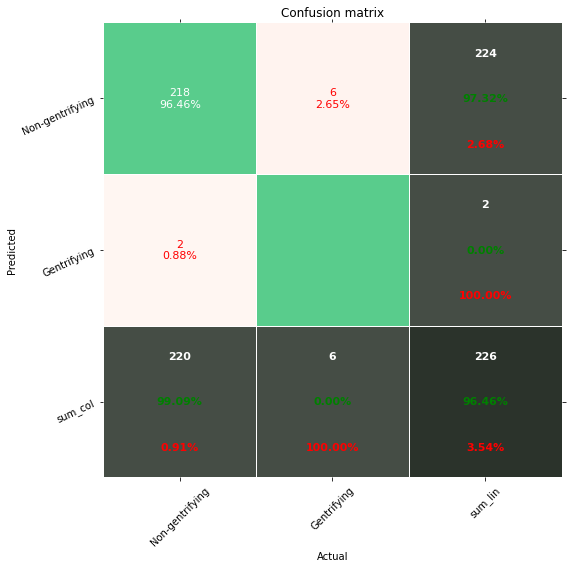

In [111]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in ["Non-gentrifying", "Gentrifying"]],
                  columns = [i for i in ["Non-gentrifying", "Gentrifying"]])

#plt.figure(figsize = (10,7))
#sns.heatmap(df_cm, annot=True, cmap="Purples", fmt='g')

from pretty_confusion_matrix import pp_matrix
cmap = "PuRd"
pp_matrix(df_cm, cmap="RdPu")

# 6.1.2 Feature Importance

In [112]:
feature_importance_model1 = pd.DataFrame(model_1.feature_importances_,index=model1_x.columns).reset_index()


In [113]:
feature_importance_model1=feature_importance_model1.rename(columns={"index":"Variable", 0:"var_impt"})


In [114]:
feature_importance_model1.sort_values(by = "var_impt", ascending=False)


,Variable,var_impt
2,average_churn,0.083750
140,Counselling and Advice Services,0.062500
20,"Alternative, Natural and Complementary",0.044375
337,Mental Health Centres and Practitioners,0.038750
371,Painting and Decorating Services,0.038125
...,...,...
201,Event Ticket Agents and Box Office,0.000000
199,Entertainment Services,0.000000
198,Energy Production,0.000000
197,Employment Agencies,0.000000


In [115]:
feature_importance_model1 = pd.merge(feature_importance_model1, label, left_on="Variable", right_on="classname", how="left")

[Text(0, 0.5, 'Importance')]

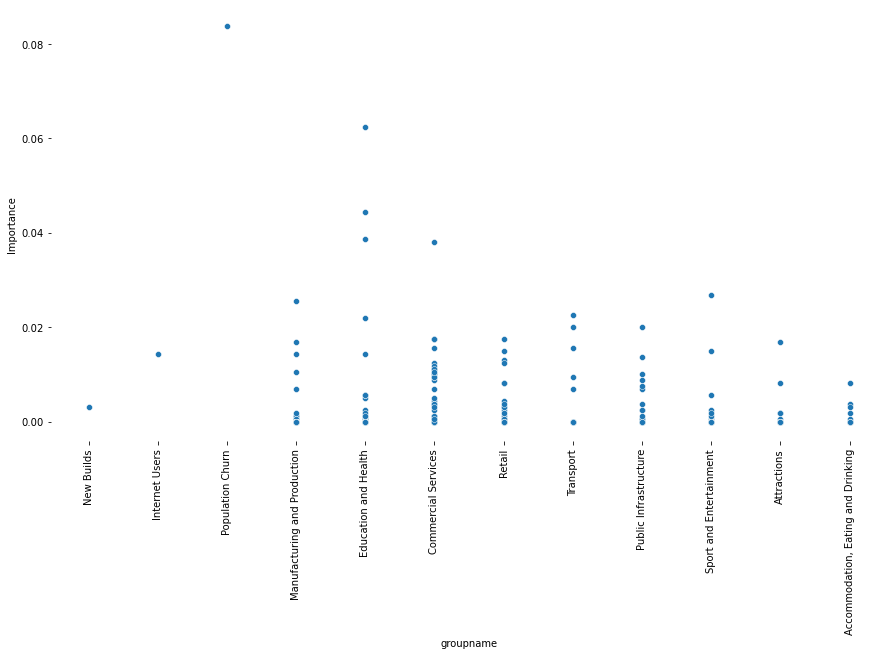

In [116]:
# visualise the most important variables

plt.figure(figsize=(15,8))
#plt.ylim(0, 0.05)
plt.xticks(rotation=90)

ax = sns.scatterplot(x="groupname", y="var_impt", data=feature_importance_model1)
ax.set(ylabel='Importance')


[Text(0, 0.5, 'Importance')]

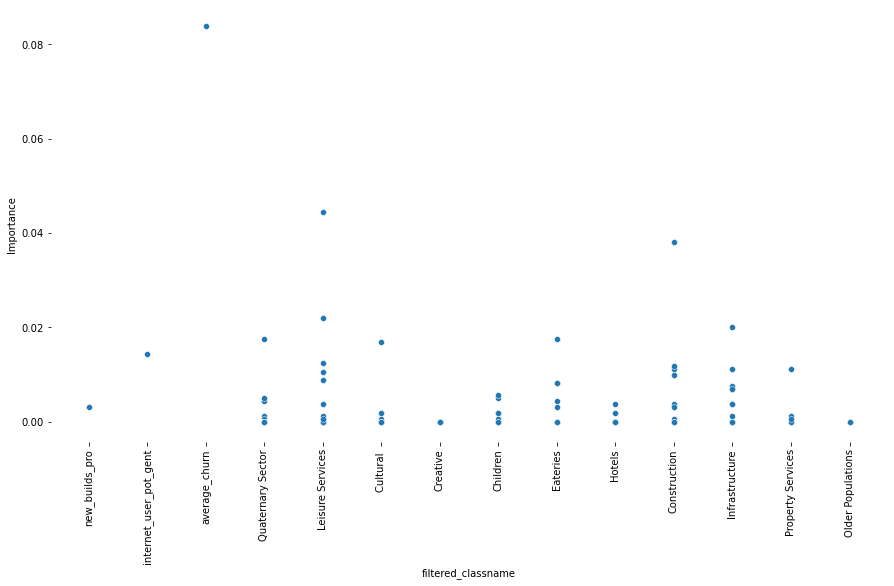

In [117]:
# visualise the most important variables

feature_importance_model1_filt = feature_importance_model1[~feature_importance_model1["filtered_classname"].str.contains("Other", na=False)]

plt.figure(figsize=(15,8))
#plt.ylim(0, 0.05)
plt.xticks(rotation=90)

ax = sns.scatterplot(x="filtered_classname", y="var_impt", data=feature_importance_model1_filt)
ax.set(ylabel='Importance')
plt.save_fig("")

In [118]:
feature_importance_model1.filtered_classname.value_counts()

Other                     400
Quaternary Sector          32
Leisure Services           28
Construction               17
Infrastructure             15
Cultural                   11
Creative                   10
Children                    9
Eateries                    7
Hotels                      6
Property Services           6
Older Populations           2
new_builds_pro              1
internet_user_pot_gent      1
average_churn               1
Name: filtered_classname, dtype: int64

In [119]:
label.filtered_classname.value_counts()

Other                     423
Quaternary Sector          33
Leisure Services           28
Construction               17
Infrastructure             15
Cultural                   11
Creative                   10
Children                    9
Eateries                    7
Property Services           6
Hotels                      6
Older Populations           2
internet_user_pot_gent      1
new_builds_pro              1
average_churn               1
Name: filtered_classname, dtype: int64

# 6.1.3 Feature Importance

In [120]:
X_train, X_test, y_train, y_test = train_test_split(model1_x, model1_y, random_state=42)
model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)

In [121]:
len(model1_y)

902

In [122]:
# # test to establish the optimal quantum of least important variables to be removed

# f1_array = []
# geo_mean_array=[]
# no_to_drop = range(1,57)

# for i in range(len(no_to_drop)):
#     to_drop = feature_importance.sort_values(by = "var_impt", ascending=False)[-no_to_drop[i]:len(feature_importance)]
#     to_drop_list = to_drop.reset_index().iloc[:,1]
#     df_01_data_dropped = model1_x[:]
#     df_01_data_dropped = df_01_data_dropped.drop(columns=to_drop_list)
#     x_train_dropped, x_test_dropped, y_train, y_test = train_test_split(df_01_data_dropped, model1_y, test_size=0.3, random_state=42)
#     brf2 = model_1.fit(x_train_dropped, y_train)
#     y_pred = brf2.predict(x_test_dropped)
#     f1 = f1_score(y_test, y_pred, average="weighted")
#     f1_array.append(f1)
#     geo_mean = geometric_mean_score(y_test,y_pred)
#     geo_mean_array.append(geo_mean)
   

In [123]:
#  df_01_data_dropped = model1_x[:]
#     df_01_data_dropped = df_01_data_dropped.drop(columns=to_drop_list)
#     x_train_dropped, x_test_dropped, y_train, y_test = train_test_split(df_01_data_dropped, model1, stratify=label, test_size=0.3, random_state=42)
#     brf2 = model1.fit(x_train_dropped, y_train.values.ravel())
#     y_pred = brf2.predict(x_test_dropped)
#     f1 = f1_score(y_test, y_pred, average="weighted")
#     f1_array.append(f1)
#     geo_mean = geometric_mean_score(y_test.values.ravel(),y_pred)
#     geo_mean_array.append(geo_mean)

# 6.2 Model 2

In [124]:
#model_2 = AdaBoostClassifier(random_state=42,learning_rate= list(model2_params.values())[0], n_estimators= list(model2_params.values())[1])
model_2 = AdaBoostClassifier(random_state=42,learning_rate= 0.01, n_estimators= 4900)

X_train, X_test, y_train, y_test = train_test_split(model2_x, model2_y , test_size=0.3, random_state=42)
model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

model_2_TP = TP
model_2_FP = FP
model_2_TN = TN
model_2_FN = FN

model_2_acc = accuracy_score(y_pred, y_test)
model_2_pre = precision_score(y_pred, y_test, average="weighted")
model_2_rec = recall_score(y_pred, y_test, average="weighted")
model_2_f1 = f1_score(y_test, y_pred, average = "weighted")

model_2_pred = TP+FP

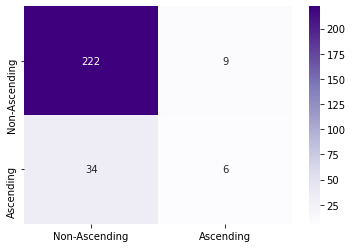

In [181]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in ["Non-Ascending", "Ascending"]],
                  columns = [i for i in ["Non-Ascending", "Ascending"]])

#plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="Purples", fmt='g')

from pretty_confusion_matrix import pp_matrix
#cmap = "PuRd"
#pp_matrix(df_cm, cmap="RdPu")

# 6.2.2 Feature Importance

In [126]:
feature_importance_model2 = pd.DataFrame(model_2.feature_importances_,index=model2_x.columns).reset_index()


In [127]:
feature_importance_model2=feature_importance_model2.rename(columns={"index":"Variable", 0:"var_impt"})


In [128]:
feature_importance_model2.sort_values(by = "var_impt", ascending=False)


,Variable,var_impt
16,Allotments,0.053061
186,Electrical Features,0.036531
464,"Solicitors, Advocates and Notaries Public",0.030816
368,Painting and Decorating Services,0.026531
196,Entertainment Services,0.026327
...,...,...
208,Fertilisers,0.000000
207,Ferry and Cruise Companies,0.000000
206,Ferries and Ferry Terminals,0.000000
204,Fencing and Drystone Walling Services,0.000000


In [129]:
feature_importance_model2 = feature_importance_model2.merge(label, left_on="Variable", right_on="classname")


[Text(0, 0.5, 'Importance')]

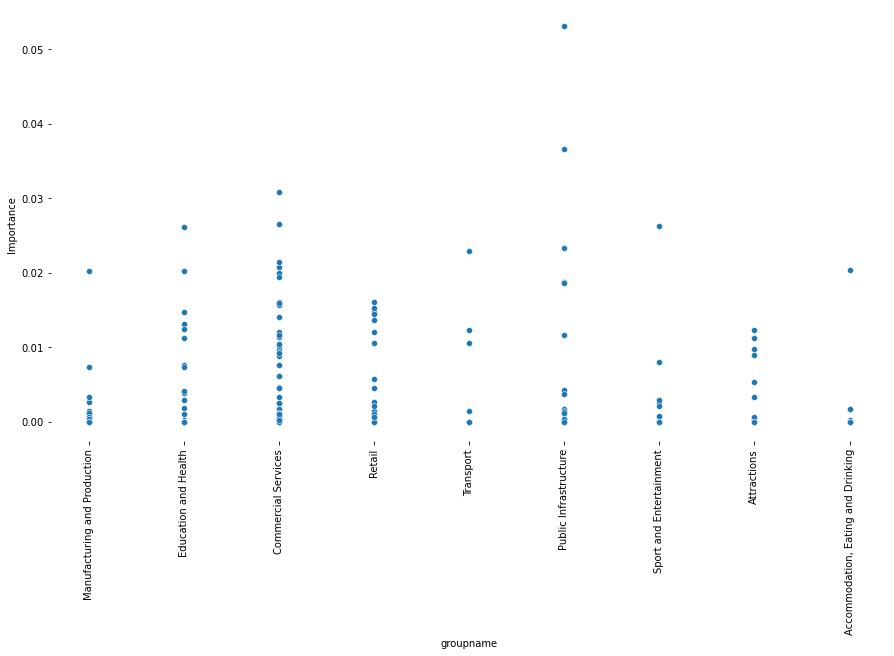

In [130]:
# visualise the most important variables

plt.figure(figsize=(15,8))
#plt.ylim(0, 0.05)
plt.xticks(rotation=90)

ax = sns.scatterplot(x="groupname", y="var_impt", data=feature_importance_model2)
ax.set(ylabel='Importance')


[Text(0, 0.5, 'Importance')]

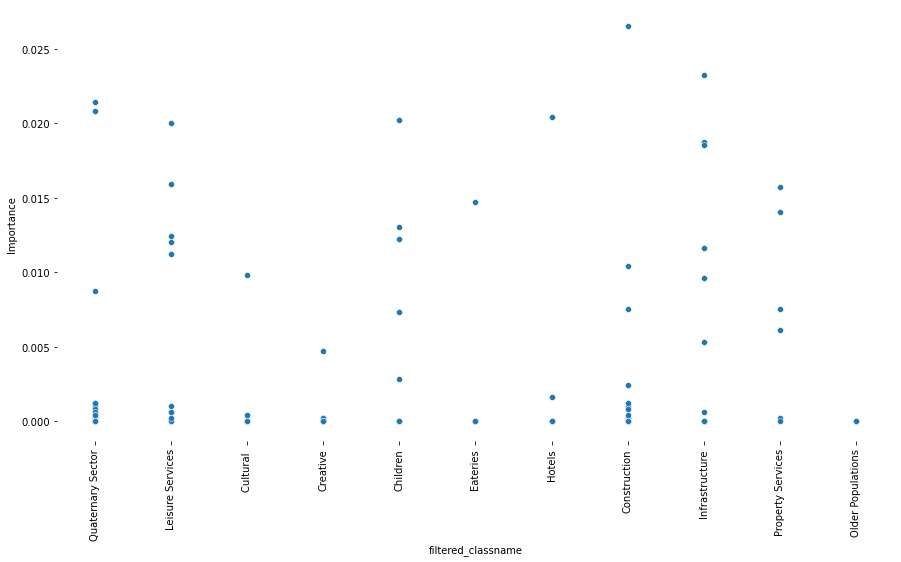

In [131]:
feature_importance_model2_filt = feature_importance_model2[~feature_importance_model2["filtered_classname"].str.contains("Other", na=False)]

plt.figure(figsize=(15,8))
#plt.ylim(0, 0.05)
plt.xticks(rotation=90)

ax = sns.scatterplot(x="filtered_classname", y="var_impt", data=feature_importance_model2_filt)
ax.set(ylabel='Importance')

In [132]:
feature_importance_model2.filtered_classname.value_counts()

Other                400
Quaternary Sector     32
Leisure Services      28
Construction          17
Infrastructure        15
Cultural              11
Creative              10
Children               9
Eateries               7
Hotels                 6
Property Services      6
Older Populations      2
Name: filtered_classname, dtype: int64

# 6.3 Model 3

In [182]:
#model_3 = AdaBoostClassifier(random_state=42,learning_rate= list(model3_params.values())[0], n_estimators= list(model3_params.values())[1])
model_3 = AdaBoostClassifier(random_state=42,learning_rate= 0.1, n_estimators= 1400)

X_train, X_test, y_train, y_test = train_test_split(model2_x, model3_y , test_size=0.3, random_state=42)
model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

model_3_TP = TP
model_3_FP = FP
model_3_TN = TN
model_3_FN = FN

model_3_acc = accuracy_score(y_pred, y_test)
model_3_pre = precision_score(y_pred, y_test, average="weighted")
model_3_rec = recall_score(y_pred, y_test, average="weighted")
model_3_f1 = f1_score(y_test, y_pred, average = "weighted")

model_3_pred = TP+FP

In [183]:
model_3_pred

15

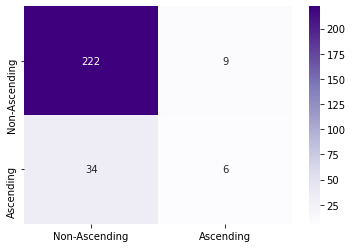

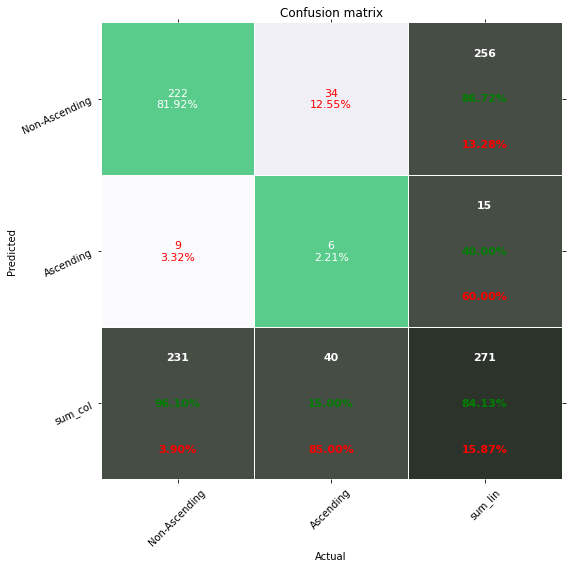

In [188]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = [i for i in ["Non-Ascending", "Ascending"]],
                  columns = [i for i in ["Non-Ascending", "Ascending"]])

#plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="Purples", fmt='g')

from pretty_confusion_matrix import pp_matrix
cmap = "PuRd"
pp_matrix(df_cm, cmap="Purples")

# 6.3.2 Feature Importance

In [135]:
feature_importance_model3 = pd.DataFrame(model_3.feature_importances_,index=model2_x.columns).reset_index()


In [136]:
feature_importance_model3=feature_importance_model3.rename(columns={"index":"Variable", 0:"var_impt"})


In [137]:
feature_importance_model3.sort_values(by = "var_impt", ascending=False)


,Variable,var_impt
3,Accountants and Auditors,0.042857
260,"Headquarters, Administration and Central Offices",0.037143
29,Architectural and Building Related Consultants,0.036429
83,Cash Machines,0.033571
398,"Poultry Farming, Equipment and Supplies",0.030714
...,...,...
220,Florists,0.000000
219,Fishmongers,0.000000
216,Fish and Chip Shops,0.000000
214,First Aid Training,0.000000


In [138]:
feature_importance_model3 = feature_importance_model3.merge(label, left_on="Variable", right_on="classname", how="left")


[Text(0, 0.5, 'Importance')]

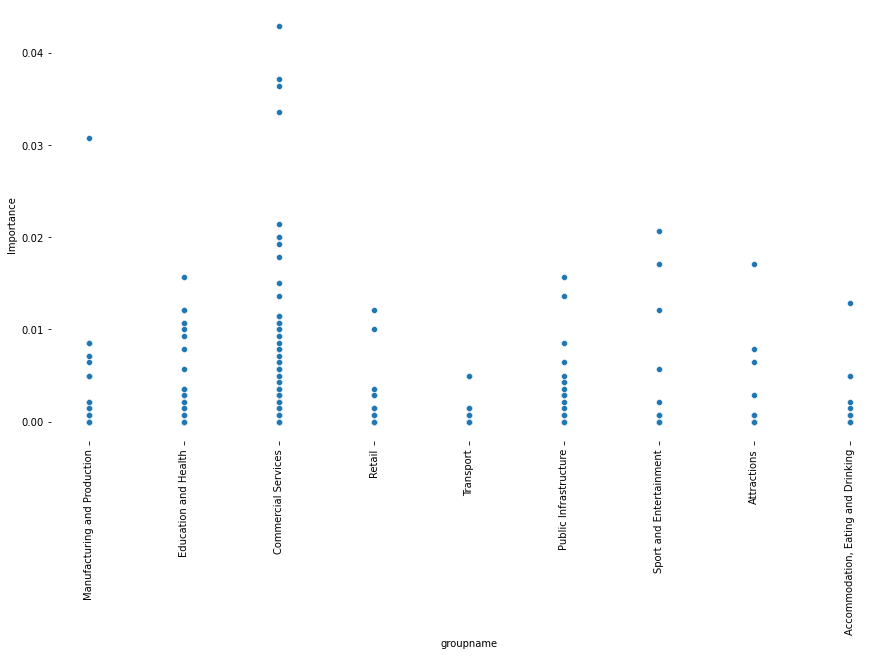

In [139]:
# visualise the most important variables

plt.figure(figsize=(15,8))
#plt.ylim(0, 0.05)
plt.xticks(rotation=90)

ax = sns.scatterplot(x="groupname", y="var_impt", data=feature_importance_model3)
ax.set(ylabel='Importance')


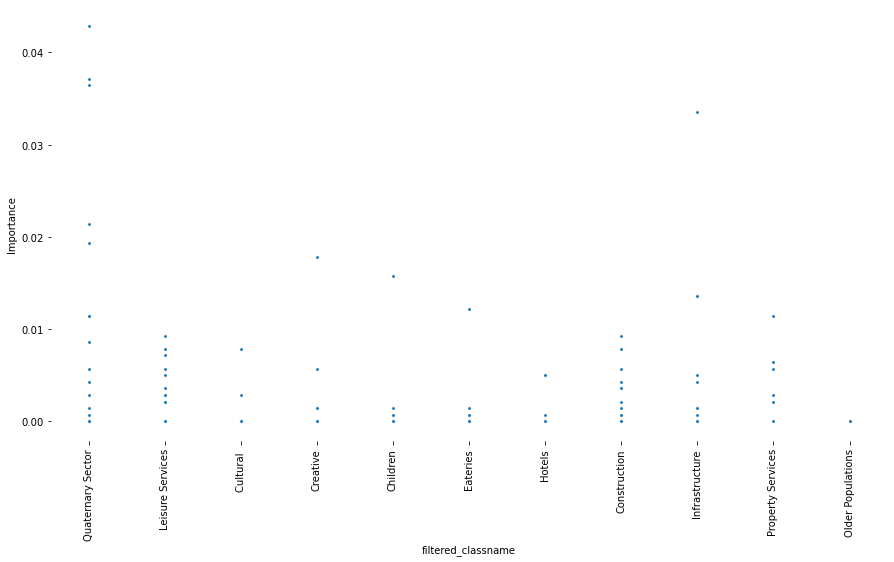

In [198]:
feature_importance_model3_filt = feature_importance_model3[~feature_importance_model3["filtered_classname"].str.contains("Other", na=False)]

plt.figure(figsize=(15,8))
#plt.ylim(0, 0.05)
plt.xticks(rotation=90)

ax = sns.scatterplot(x="filtered_classname", y="var_impt", data=feature_importance_model3_filt,s=10)
ax.set(ylabel='Importance')
plt.savefig(os.path.join("Figures", "FeatureImp.png"))

In [206]:
feature_importance_model3.describe()

,var_impt,Unnamed: 0
count,543.000000,543.000000
mean,0.001842,9389.885820
std,0.004889,16737.021122
min,0.000000,0.000000
25%,0.000000,627.000000
50%,0.000000,2082.000000
75%,0.000714,8630.500000
max,0.042857,97358.000000


In [216]:
radar_2 = feature_importance_model3.groupby("filtered_classname").mean().sort_values(by="var_impt", ascending=False)
radar_2

,var_impt,Unnamed: 0
filtered_classname,,
Quaternary Sector,0.006362,4393.437500
Infrastructure,0.004905,6357.800000
Property Services,0.004762,1766.666667
Creative,0.002643,3908.400000
Construction,0.002353,2290.058824
Children,0.002143,6558.888889
Eateries,0.002143,7905.428571
Hotels,0.001786,5232.000000
Leisure Services,0.001735,7366.678571


# 7. Predictions

# 7.1 2022 Data
# 7.1.1 POI

# 7.1.2 Forecast Population Churn

In [142]:
# df = pop_churn_kent[['chn1997',
#  'chn1998',
#  'chn1999',
#  'chn2000',
#  'chn2001',
#  'chn2002',
#  'chn2003',
#  'chn2004',
#  'chn2005',
#  'chn2006',
#  'chn2007',
#  'chn2008',
#  'chn2009',
#  'chn2010',
#  'chn2011',
#  'chn2012',
#  'chn2013',
#  'chn2014',
#  'chn2015',
#  'chn2016',
#  'chn2017',
#  'chn2018',
#  'chn2019']]

# df = df.reset_index()
# df = df.drop(["LSOA11CD"], axis=1)
# df["2020"] = np.nan
# df["2021"] = np.nan
# df["2022"] = np.nan
# df = df.T
# index = pd.Index(range(1997, 2023, 1))

# df = df.set_index(index)

# df. apply(pd.to_numeric) 
# df.dtypes

In [143]:
# # Do the original interpolation

# from scipy.optimize import curve_fit

# df.interpolate(method='nearest', xis=0, inplace=True)

# # # Display result
# # print ('Interpolated data:')
# # print (df)
# # print ()

# # Function to curve fit to the data
# def func(x, a, b, c, d):
#     return a * (x ** 3) + b * (x ** 2) + c * x + d

# # Initial parameter guess, just to kick off the optimization
# guess = (0.5, 0.5, 0.5, 0.5)

# # Create copy of data to remove NaNs for curve fitting
# fit_df = df.dropna()

# # Place to store function parameters for each column
# col_params = {}

# # Curve fit each column
# for col in fit_df.columns:
#     # Get x & y
#     x = fit_df.index.astype(float).values
#     y = fit_df[col].values
#     # Curve fit column and get curve parameters
#     params = curve_fit(func, x, y, guess)
#     # Store optimized parameters
#     col_params[col] = params[0]

# # Extrapolate each column
# for col in df.columns:
#     # Get the index values for NaNs in the column
#     x = df[pd.isnull(df[col])].index.astype(float).values
#     # Extrapolate those points with the fitted function
#     df[col][x] = func(x, *col_params[col])

# # Display result
# print ('Extrapolated data:')
# print (df)
# print ()

# print ('Data was extrapolated with these column functions:')
# for col in col_params:
#     print ('f_{}(x) = {:0.3e} x^3 + {:0.3e} x^2 + {:0.4f} x + {:0.4f}'.format(col, *col_params[col]))

In [144]:
# my_new_df = pop_churn_kent
# transposed = pd.DataFrame(my_new_df.T)
# df = transposed.iloc[3:-1]
# df = df. apply(pd. to_numeric) 
# x = df.interpolate(method='nearest', xis=0, inplace=True)
# # Plotting with seaborn
# #fig,ax = plt.subplots()
# #sns.lineplot(x=transposed.index,y=transposed.iloc[3:],marker='*',ax = ax)
# transposed.iloc[3:].plot(legend=False)
# plt.show()

# Ok that clearly didn't work, so just work out average churn between 2018 to 2019..

In [145]:
#pop_churn_kent =  pop_churn_kent.set_index("LSOA11CD")

In [146]:
pop_churn_kent_18_19 = pop_churn_kent.iloc[:, 25:]

In [147]:
pop_churn_kent_18_19["average_churn"] = pop_churn_kent_18_19.mean(axis=1)

In [148]:
pop_churn_kent_18_19 = pop_churn_kent_18_19.reset_index()

In [149]:
pop_churn_kent_18_19 = pop_churn_kent_18_19[["LSOA11CD", "average_churn"]]

# 8. Apply to whole dataset`

# 8.1 Model 1

In [150]:
model1_all = pd.DataFrame(model_1.predict(model1_x))
model1_all.value_counts()

0.0    866
1.0     36
dtype: int64

In [151]:
# Plot

model1_all["LSOA11CD"] = lsoa_2011["LSOA11CD"]
model1_all = pd.merge(lsoa_2011, model1_all, on="LSOA11CD")
model1_all = model1_all.rename(columns={0:"Gent_Status"})

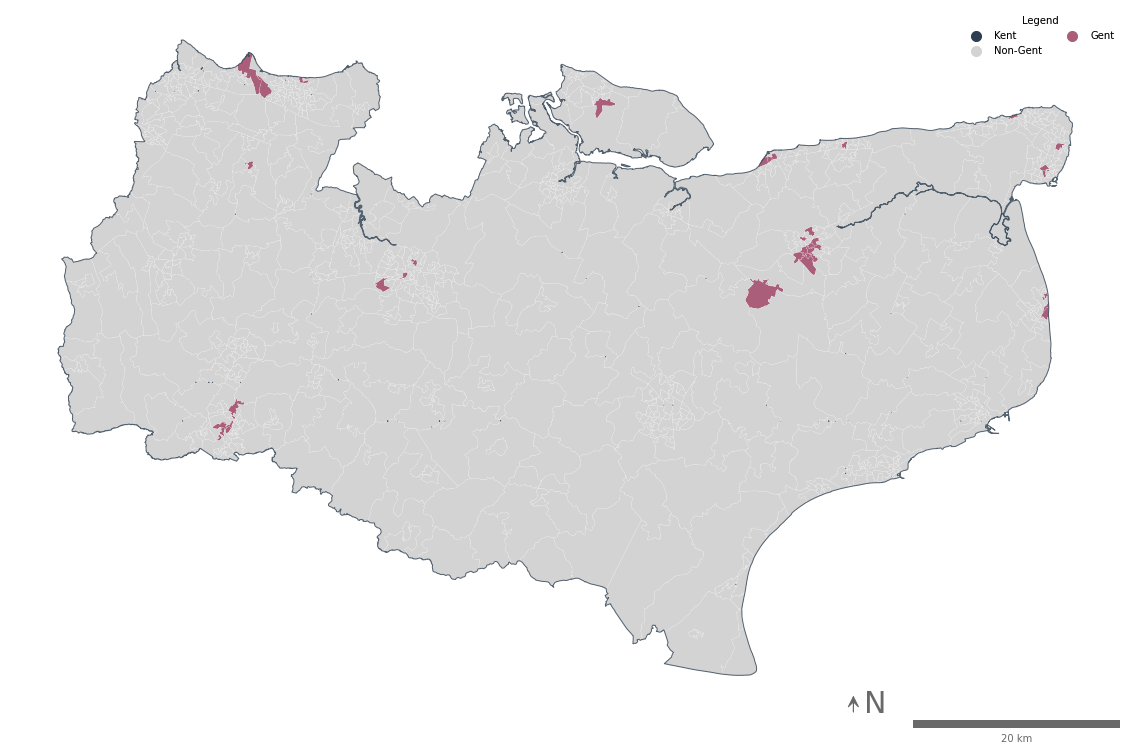

In [152]:
# Filter by status, allowing control over colors of map
gent = model1_all.loc[model1_all['Gent_Status'] == 1]
nongent = model1_all.loc[model1_all['Gent_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

gent.plot(ax=ax, facecolor="#AA5E79")
nongent.plot(ax=ax, facecolor="lightgrey")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Gent","Gent"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
#plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()

# 8.2 Model 2

In [153]:
model2_all = pd.DataFrame(model_2.predict(model2_x))
model2_all.value_counts()

0.0    815
1.0     87
dtype: int64

In [154]:
# Plot

model2_all["LSOA11CD"] = lsoa_2011["LSOA11CD"]
model2_all = pd.merge(lsoa_2011, model2_all, on="LSOA11CD")
model2_all = model2_all.rename(columns={0:"ASC_Status"})

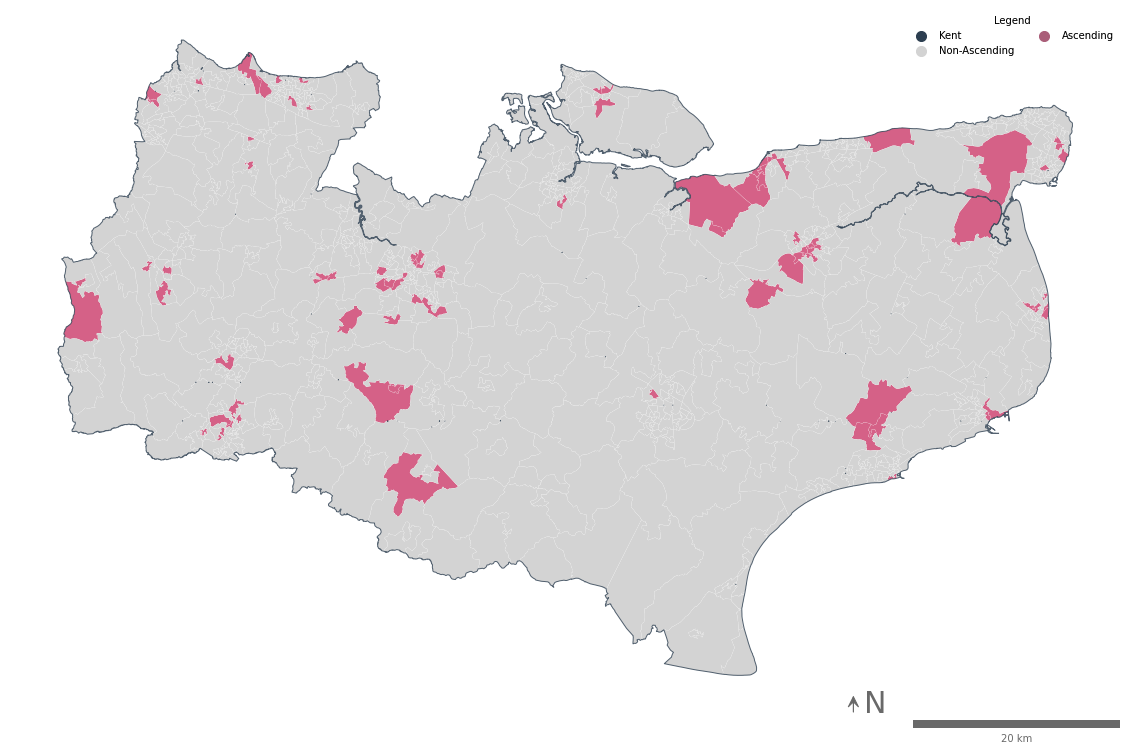

In [155]:
# Filter by status, allowing control over colors of map
asc = model2_all.loc[model2_all['ASC_Status'] == 1]
non_asc = model2_all.loc[model2_all['ASC_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

asc.plot(ax=ax, facecolor="#d56187")
non_asc.plot(ax=ax, facecolor="lightgrey")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Ascending","Ascending"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
#plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()

# 8.3 Model 3

In [156]:
model3_all = pd.DataFrame(model_3.predict(model2_x))
model3_all.value_counts()

0.0    798
1.0    104
dtype: int64

In [224]:
model3_all

,LSOA11CD,LSOA11NM,geometry,ASC_Status
0,E01023972,Ashford 006A,"POLYGON ((602494.344 141509.244, 602498.426 14...",0.0
1,E01023973,Ashford 005A,"POLYGON ((601527.620 141293.178, 601527.125 14...",0.0
2,E01023974,Ashford 007A,"POLYGON ((599609.242 141534.213, 599612.382 14...",0.0
3,E01023975,Ashford 007B,"POLYGON ((599541.509 141383.033, 599540.728 14...",0.0
4,E01023976,Ashford 008A,"POLYGON ((600185.589 141361.026, 600187.479 14...",0.0
...,...,...,...,...
897,E01033211,Dover 012F,"POLYGON ((631998.105 141862.895, 632000.000 14...",0.0
898,E01033212,Shepway 014C,"POLYGON ((622628.323 135841.733, 622619.469 13...",0.0
899,E01033213,Shepway 002E,"POLYGON ((620229.159 139097.666, 620229.125 13...",0.0
900,E01033214,Shepway 002F,"POLYGON ((620865.861 139274.269, 620856.245 13...",0.0


In [225]:
predict = model3_all["ASC_Status"].to_numpy()

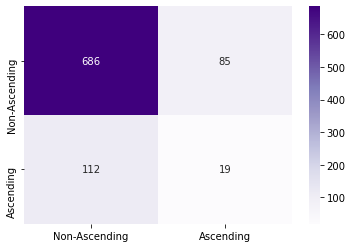

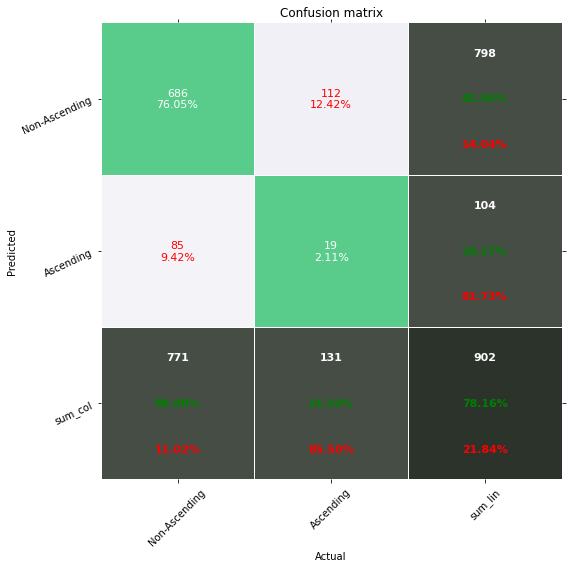

In [227]:
cm = confusion_matrix(model2_y, predict)

df_cm = pd.DataFrame(cm, index = [i for i in ["Non-Ascending", "Ascending"]],
                  columns = [i for i in ["Non-Ascending", "Ascending"]])

#plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, cmap="Purples", fmt='g')

from pretty_confusion_matrix import pp_matrix
cmap = "PuRd"
pp_matrix(df_cm, cmap="Purples")

In [222]:
df = pd.DataFrame(model2_y)
df

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
897,0.0
898,0.0
899,1.0
900,1.0


In [157]:
# Plot

model3_all["LSOA11CD"] = lsoa_2011["LSOA11CD"]
model3_all = pd.merge(lsoa_2011, model3_all, on="LSOA11CD")
model3_all = model3_all.rename(columns={0:"ASC_Status"})

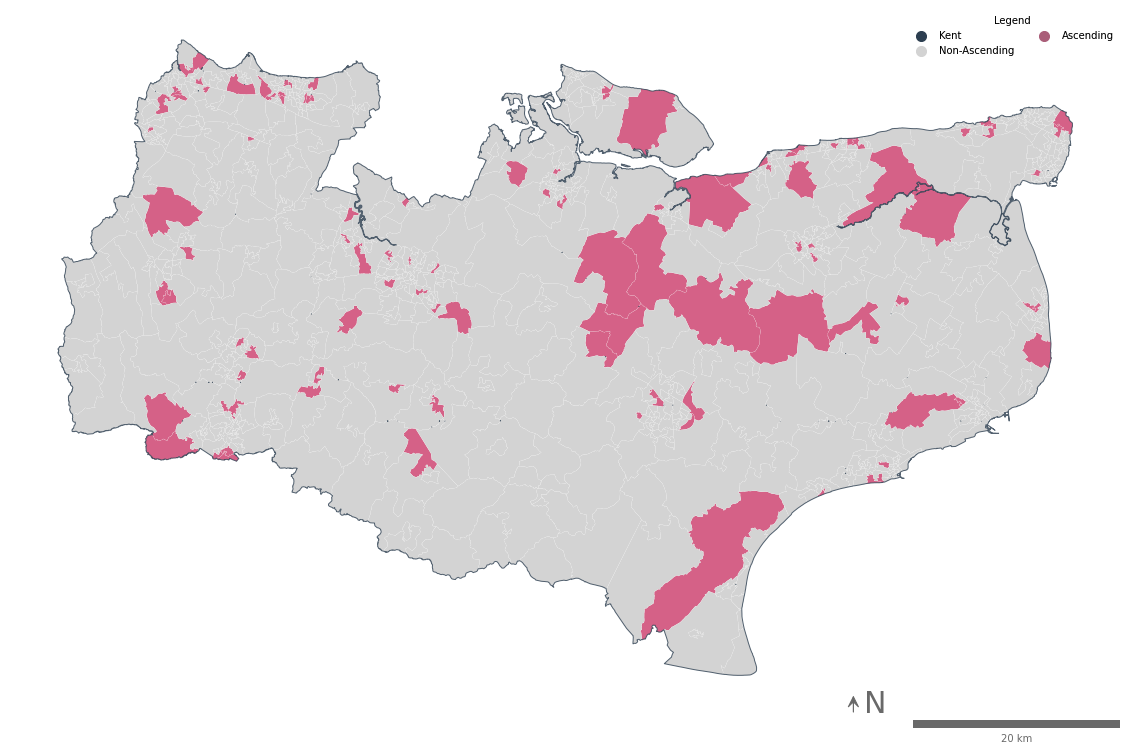

In [158]:
# Filter by status, allowing control over colors of map
asc = model3_all.loc[model3_all['ASC_Status'] == 1]
non_asc = model3_all.loc[model3_all['ASC_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

asc.plot(ax=ax, facecolor="#d56187")
non_asc.plot(ax=ax, facecolor="lightgrey")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Ascending","Ascending"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
#plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()

# 9. Predict

In [159]:
# Model 1 X

model1_x_predict = poi_2018_2022_change_model_1
model1_x_predict = model1_x_predict.drop(["LSOA11CD"], axis=1)

In [160]:
# Model 2 X

model2_x_predict = poi_2018_2022_change_model_2
model2_x_predict = model2_x_predict.drop(["LSOA11CD"], axis=1)

# 9.1 Model 1 - GENT

In [161]:
# Predict
model_4_predictions = pd.DataFrame(model_1.predict(model1_x_predict))

In [162]:
model_4_predictions.value_counts()

0.0    901
1.0      1
dtype: int64

In [163]:
# Plot

model_4_predictions["LSOA11CD"] = lsoa_2011["LSOA11CD"]
model_4_predictions = pd.merge(lsoa_2011, model_4_predictions, on="LSOA11CD")
model_4_predictions = model_4_predictions.rename(columns={0:"Gent_Status"})

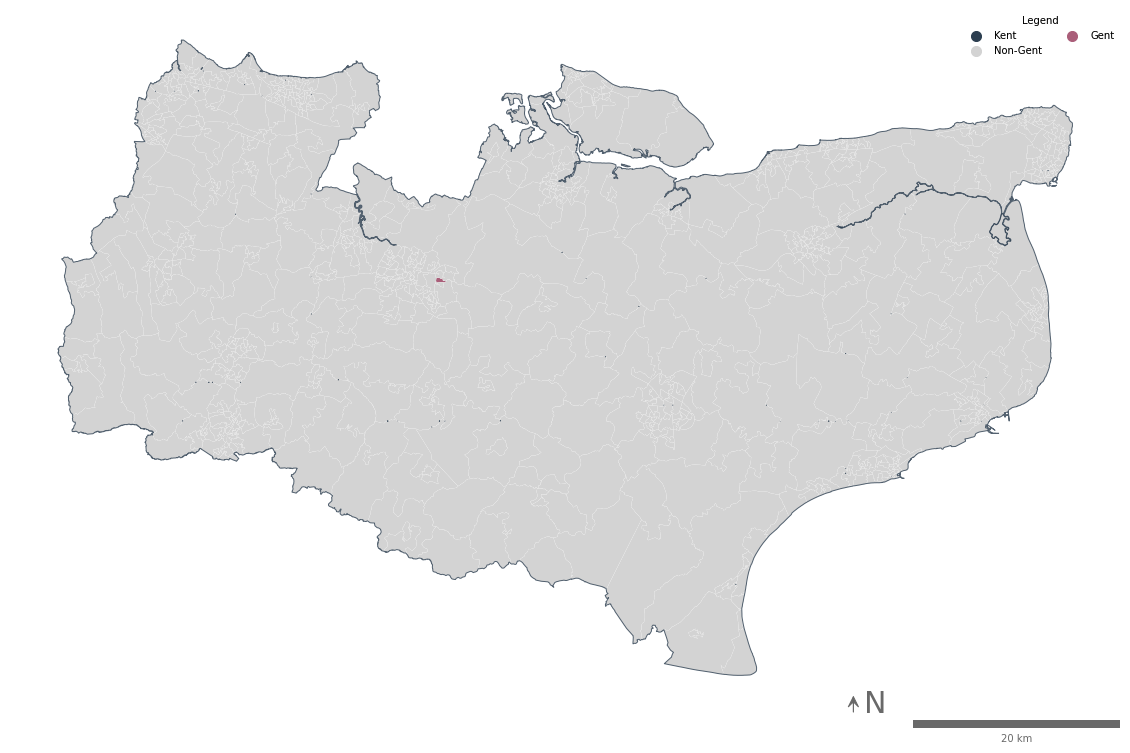

In [164]:
# Filter by status, allowing control over colors of map
gent = model_4_predictions.loc[model_4_predictions['Gent_Status'] == 1]
nongent = model_4_predictions.loc[model_4_predictions['Gent_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

gent.plot(ax=ax, facecolor="#AA5E79")
nongent.plot(ax=ax, facecolor="lightgrey")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Gent","Gent"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
#plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()

# 8.2 Model 2 

In [165]:
model_5_predictions = pd.DataFrame(model_2.predict(model2_x_predict))

In [166]:
model_5_predictions.value_counts()

0.0    882
1.0     20
dtype: int64

In [167]:
# Plot

model_5_predictions["LSOA11CD"] = lsoa_2011["LSOA11CD"]
model_5_predictions = pd.merge(lsoa_2011, model_5_predictions, on="LSOA11CD")
model_5_predictions = model_5_predictions.rename(columns={0:"ASC_Status"})

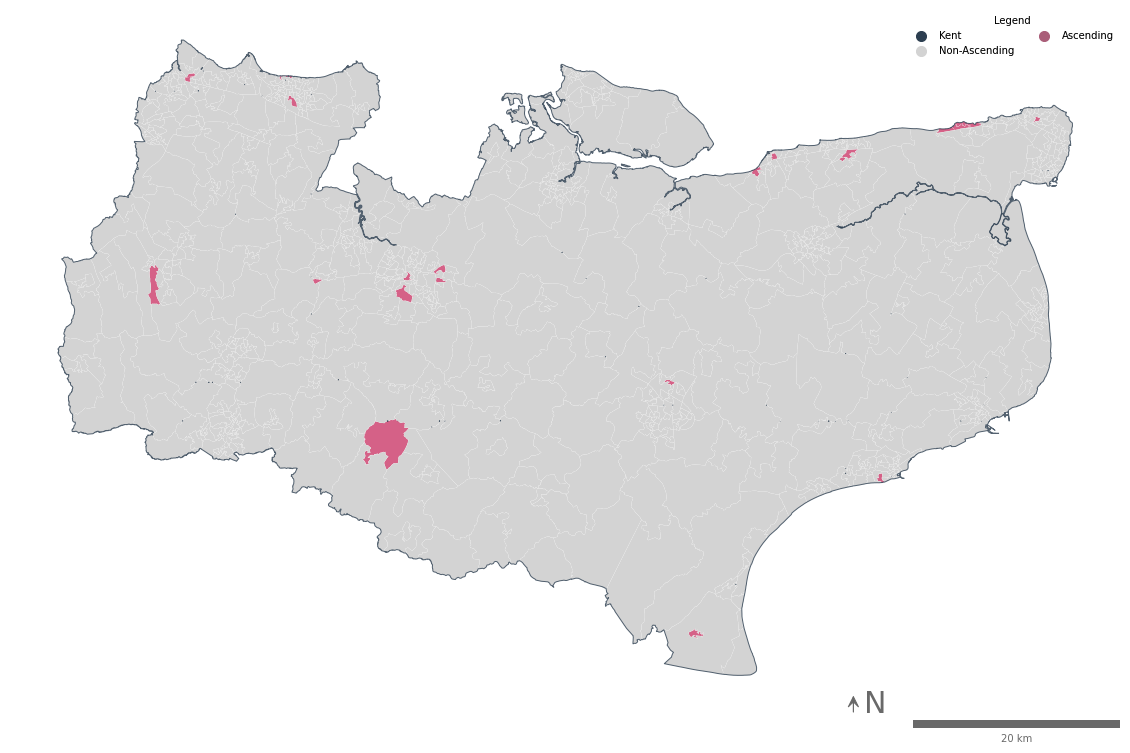

In [168]:
# Filter by status, allowing control over colors of map
asc = model_5_predictions.loc[model_5_predictions['ASC_Status'] == 1]
non_asc = model_5_predictions.loc[model_5_predictions['ASC_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

asc.plot(ax=ax, facecolor="#d56187")
non_asc.plot(ax=ax, facecolor="lightgrey")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Ascending","Ascending"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
#plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()

# 8.3 Model 3

In [169]:
model_6_predictions = pd.DataFrame(model_3.predict(model2_x_predict))

In [170]:
model_6_predictions.value_counts()

0.0    870
1.0     32
dtype: int64

In [171]:
# Plot

model_6_predictions["LSOA11CD"] = lsoa_2011["LSOA11CD"]
model_6_predictions = pd.merge(lsoa_2011, model_6_predictions, on="LSOA11CD")
model_6_predictions = model_6_predictions.rename(columns={0:"ASC_Status"})

In [241]:
lsoa_2011 = gpd.read_file(os.path.join(shapefiles, "LSOA_KENT_2011.shp"))

nc_2014 = pd.read_csv(os.path.join(clean, "level1_level2_level3_nc.csv"))
nc_2014 = pd.merge(lsoa_2011, nc_2014, on="LSOA11CD", how="left")
nc_2014 = nc_2014.set_geometry(nc_2014["geometry_x"])

In [239]:
nc_2014

,LSOA11CD,LSOA11NM_x,geometry_x,Unnamed: 0,LSOA11NM_y,Level1Cat_nc,Level2Cat,geometry_y
0,E01023972,Ashford 006A,"POLYGON ((602494.344 141509.244, 602498.426 14...",0,Ashford 006A,STB,STB,"POLYGON ((602494.344 141509.244, 602498.426 14..."
1,E01023973,Ashford 005A,"POLYGON ((601527.620 141293.178, 601527.125 14...",1,Ashford 005A,STB,STB,"POLYGON ((601527.62 141293.178, 601527.125 141..."
2,E01023974,Ashford 007A,"POLYGON ((599609.242 141534.213, 599612.382 14...",2,Ashford 007A,STB,STB,"POLYGON ((599609.242 141534.213, 599612.382 14..."
3,E01023975,Ashford 007B,"POLYGON ((599541.509 141383.033, 599540.728 14...",3,Ashford 007B,STB,STB,"POLYGON ((599541.509 141383.033, 599540.728 14..."
4,E01023976,Ashford 008A,"POLYGON ((600185.589 141361.026, 600187.479 14...",4,Ashford 008A,STB,STB,"POLYGON ((600185.589 141361.026, 600187.479000..."
...,...,...,...,...,...,...,...,...
897,E01033211,Dover 012F,"POLYGON ((631998.105 141862.895, 632000.000 14...",897,Dover 012F,STB,STB,"POLYGON ((631998.105 141862.895, 632000 141861..."
898,E01033212,Shepway 014C,"POLYGON ((622628.323 135841.733, 622619.469 13...",898,Shepway 014C,STB,STB,"POLYGON ((622628.323 135841.733, 622619.469 13..."
899,E01033213,Shepway 002E,"POLYGON ((620229.159 139097.666, 620229.125 13...",899,Shepway 002E,DEC,DEC,"POLYGON ((620229.159 139097.666, 620229.125 13..."
900,E01033214,Shepway 002F,"POLYGON ((620865.861 139274.269, 620856.245 13...",900,Shepway 002F,ASC,cluster2,"POLYGON ((620865.861 139274.269, 620856.245 13..."


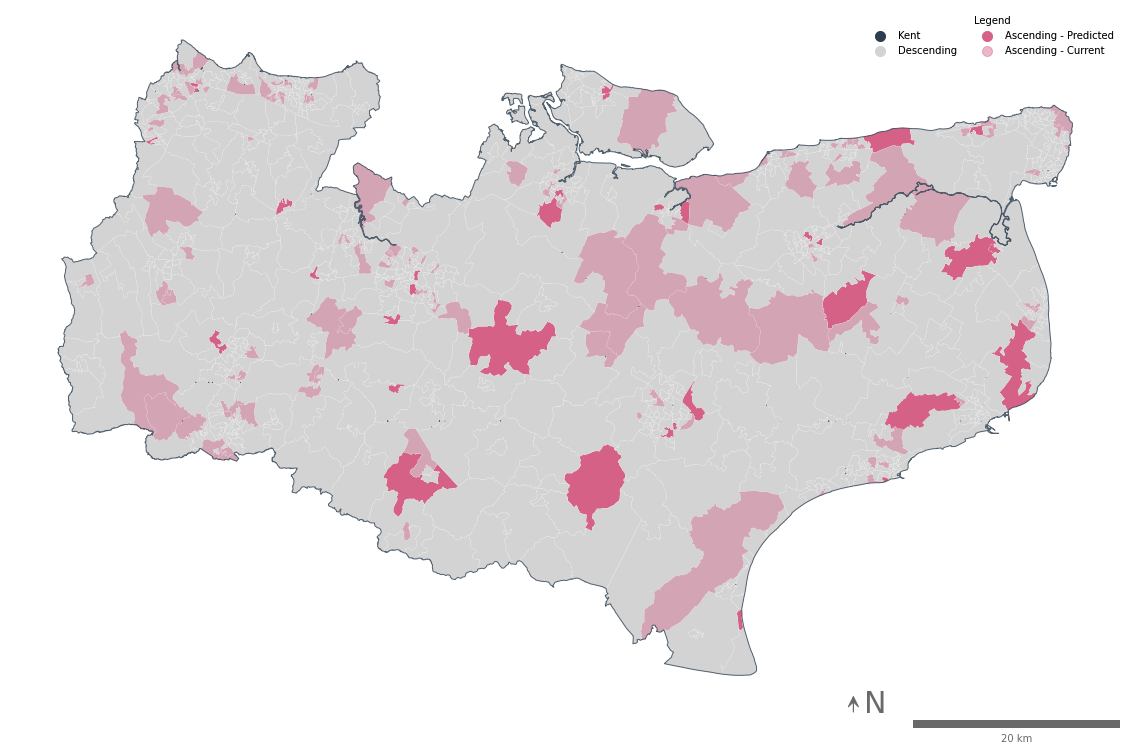

In [244]:
# Filter by status, allowing control over colors of map
asc = model_6_predictions.loc[model_6_predictions['ASC_Status'] == 1]
non_asc = model_6_predictions.loc[model_6_predictions['ASC_Status'] == 0]
nc_2014_1 = nc_2014[nc_2014["Level1Cat_nc"]=="ASC"]
#nc_2014_2 = nc_2014[nc_2014["Level1Cat_nc"]=="DEC"]
#nc_2014_3 = nc_2014[nc_2014["Level1Cat_nc"]=="STB"]

# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 

# Add north arrow

ax.text(x=620000, y=113000,s='N', fontsize=30, color="dimgray")
ax.arrow(619000, 113000, 0, 1000, length_includes_head=True, head_width=1000, head_length=500, overhang=2, zorder=100, color="dimgray")

asc.plot(ax=ax, facecolor="#d56187")
non_asc.plot(ax=ax, facecolor="lightgrey")
nc_2014_1.plot(ax=ax, facecolor="#d56187", alpha=0.4)
# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#d56187')
l4 = plt.scatter([],[], s=100, marker='o', color='#d56187', alpha=0.4)

labels = ["Kent", "Descending","Ascending - Predicted", "Ascending - Current"]
legend = ax.legend([l1, l2,l3, l4], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
plt.savefig(os.path.join("Figures", 'asc_predict.png'), transparent=True, dpi=300)

# Show map
plt.show()

# 8. Case Studies

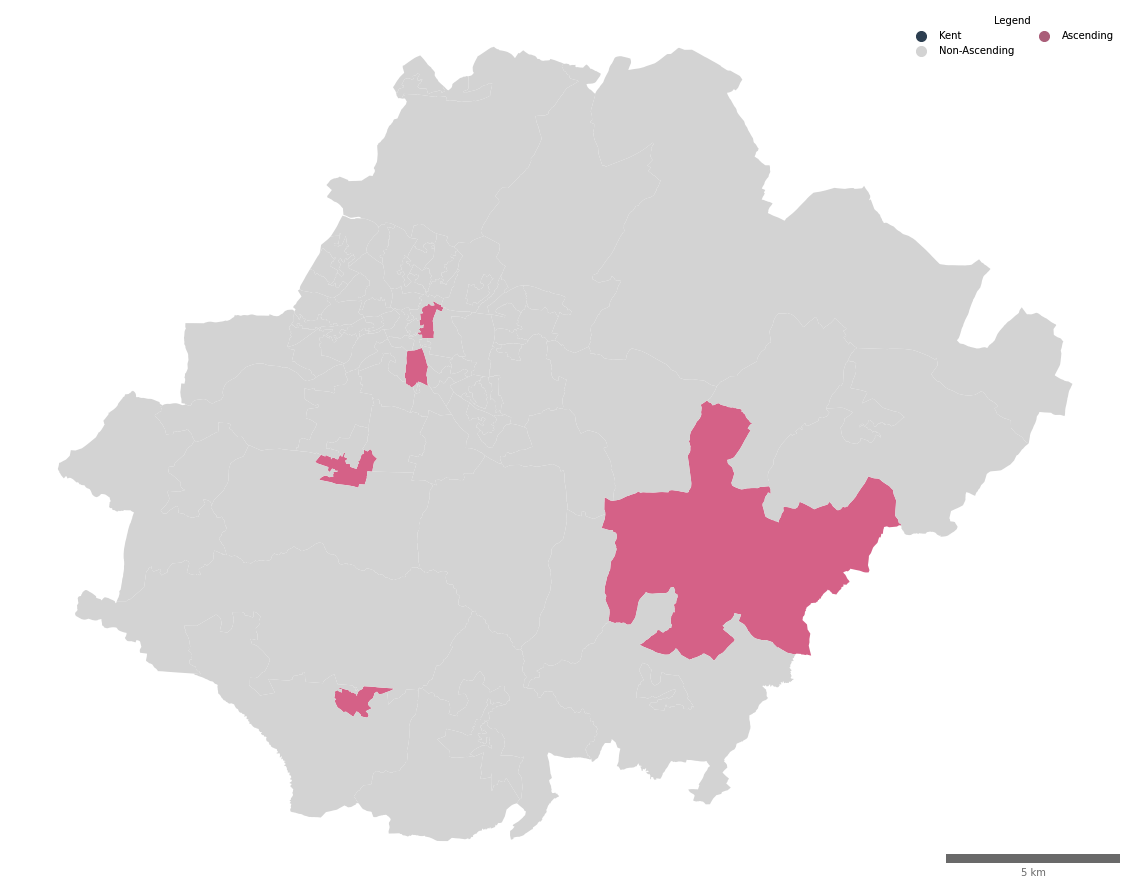

In [173]:
# Maidstone

maid = model_6_predictions[model_6_predictions['LSOA11NM'].str.contains("Maidstone")]

# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
# Filter by status, allowing control over colors of map
asc = maid.loc[maid['ASC_Status'] == 1]
non_asc = maid.loc[maid['ASC_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
#lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
#outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 


asc.plot(ax=ax, facecolor="#d56187")
non_asc.plot(ax=ax, facecolor="lightgrey")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Ascending","Ascending"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
#plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()

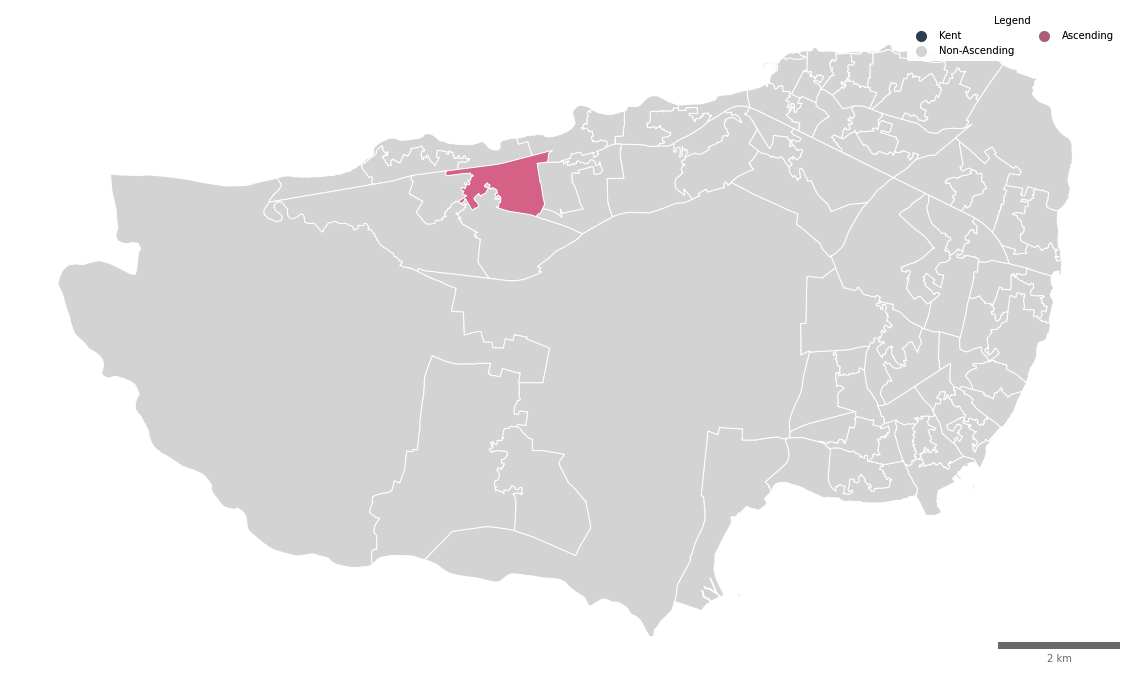

In [180]:
# Thanet

thanet = model_6_predictions[model_6_predictions['LSOA11NM'].str.contains("Thanet")]

# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
# Filter by status, allowing control over colors of map
asc = thanet.loc[thanet['ASC_Status'] == 1]
non_asc = thanet.loc[thanet['ASC_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
#lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
#outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 


asc.plot(ax=ax, facecolor="#d56187")
non_asc.plot(ax=ax, facecolor="lightgrey", edgecolor="white")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Ascending","Ascending"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
plt.savefig(os.path.join("Figures", 'predict_thanet_asc.png'), transparent=True, dpi=300)

# Show map
plt.show()

# 

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


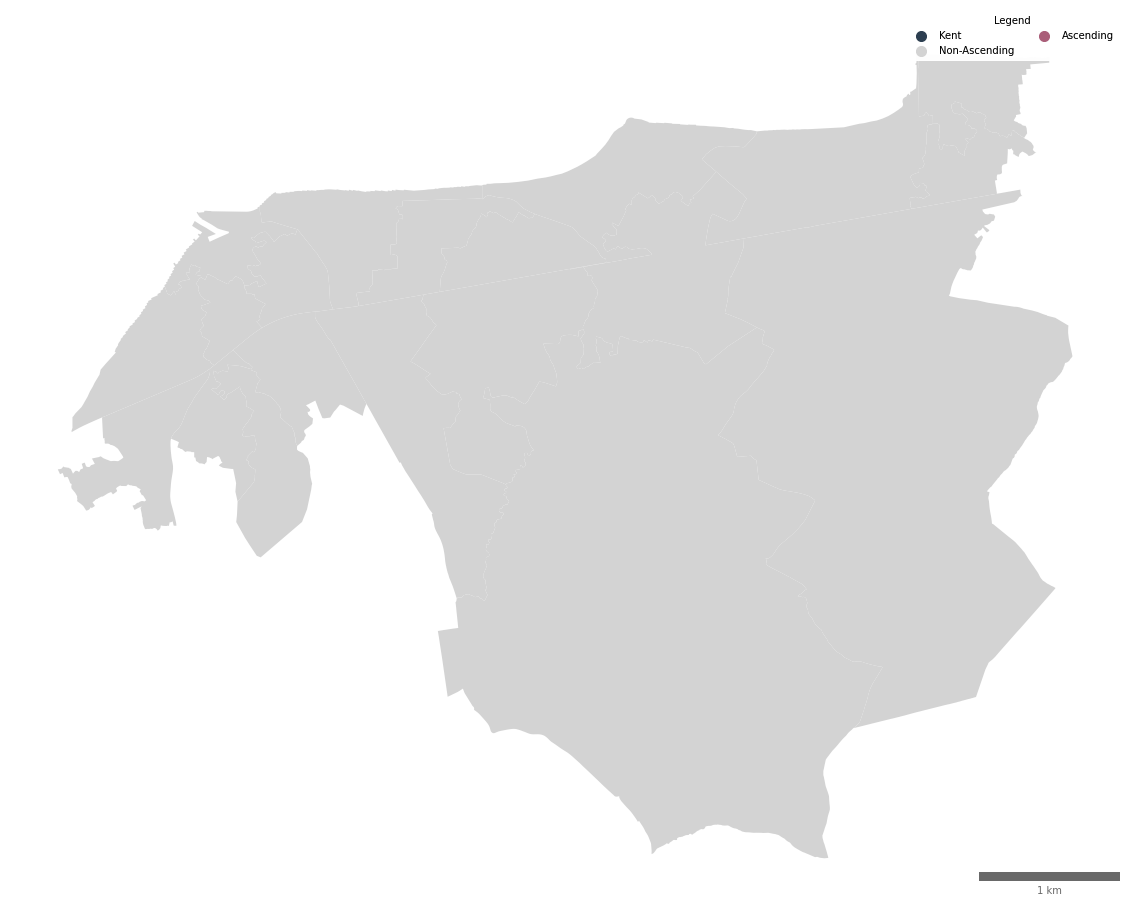

In [175]:
# whitstable

whit = model_6_predictions[model_6_predictions['LSOA11NM'].str.contains("Canterbury 008|Canterbury 007|Canterbury 004|Canterbury 005")]


# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
# Filter by status, allowing control over colors of map
asc = whit.loc[whit['ASC_Status'] == 1]
non_asc = whit.loc[whit['ASC_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
#lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
#outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=whit.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 


asc.plot(ax=ax, facecolor="#d56187")
non_asc.plot(ax=ax, facecolor="lightgrey")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Ascending","Ascending"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
#plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


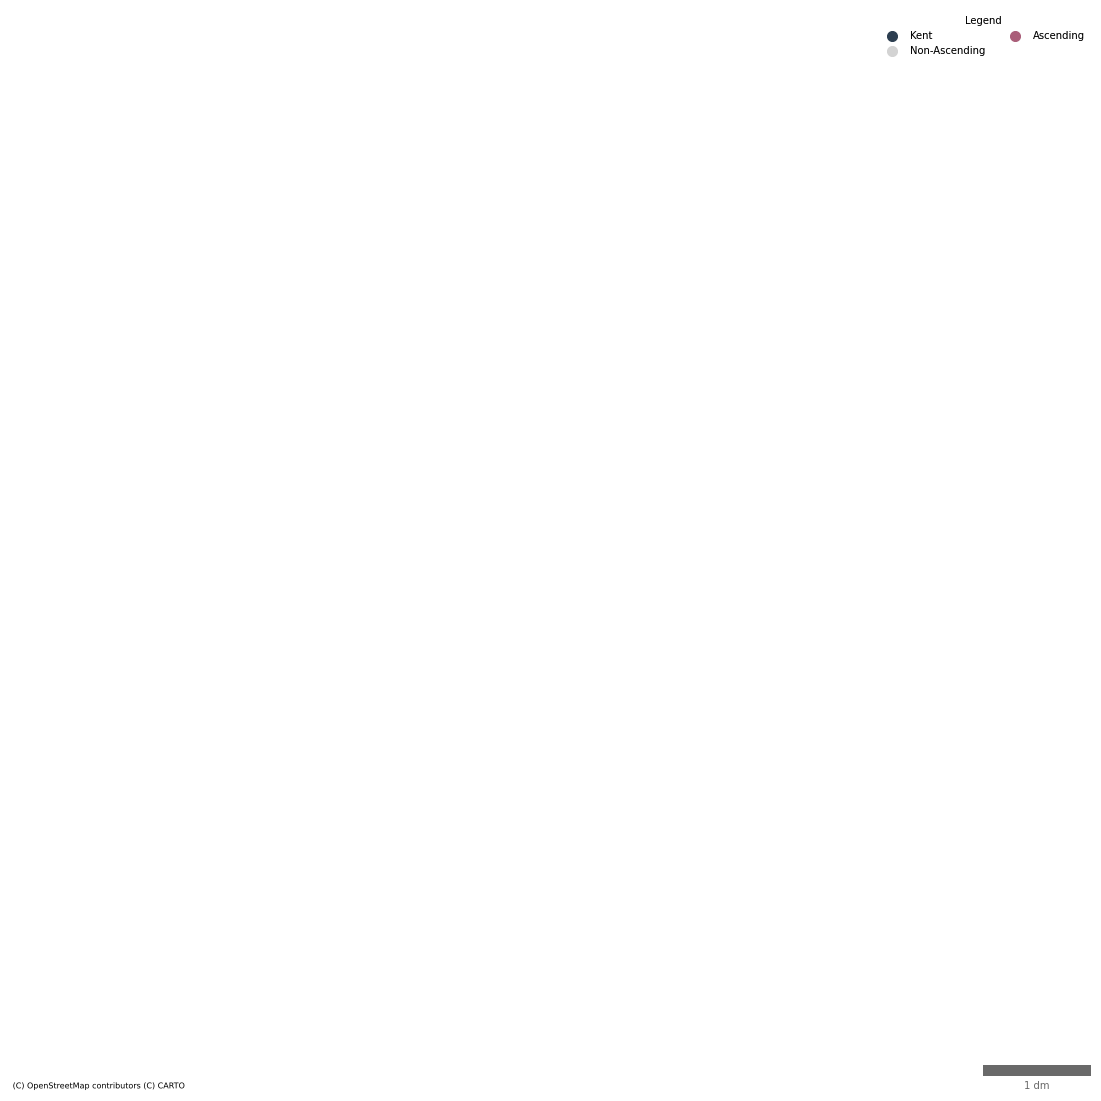

In [176]:
# Tunbridge wells

tun = model_6_predictions[model_6_predictions['LSOA11NM'].str.contains("Tunbridge Wells")]


# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
# Filter by status, allowing control over colors of map
asc = tun.loc[tun['ASC_Status'] == 1]
non_asc = tun.loc[tun['ASC_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
#lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
#outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
ctx.add_basemap(ax, crs=lsoa_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 


asc.plot(ax=ax, facecolor="#d56187")
non_asc.plot(ax=ax, facecolor="lightgrey")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Ascending","Ascending"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
#plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()

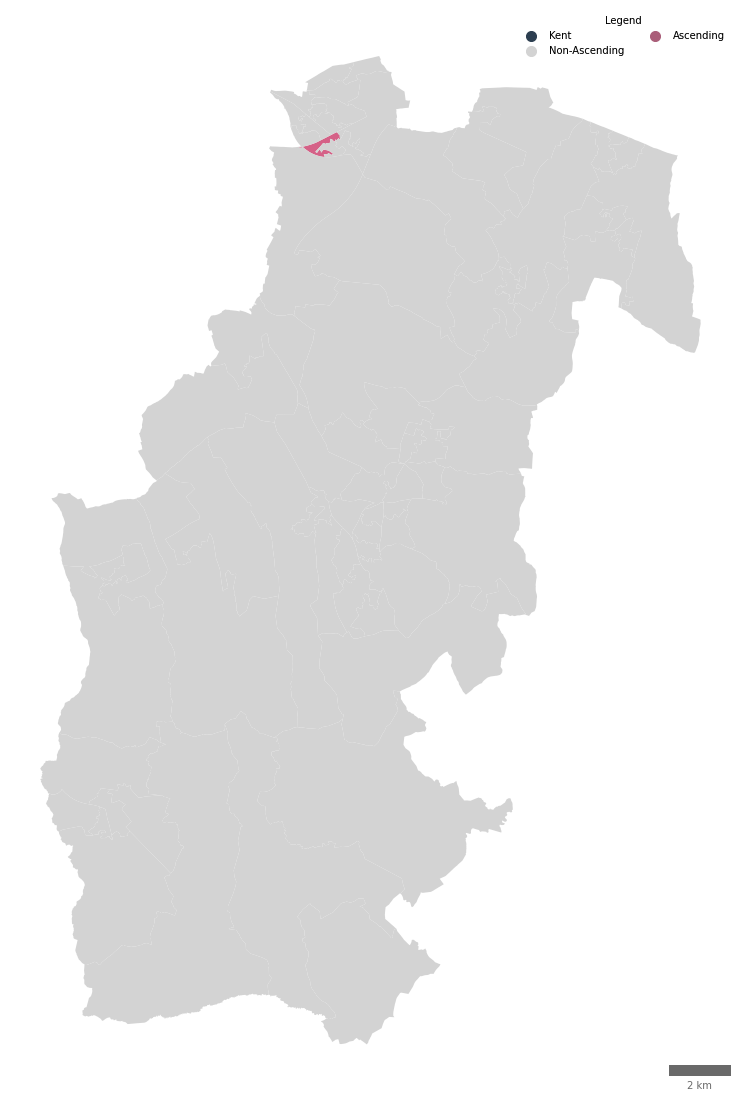

In [177]:
# Sevenoaks 

sev = model_6_predictions[model_6_predictions['LSOA11NM'].str.contains("Sevenoaks")]


# Visulise previous data on gentrification

# Filter by status, allowing control over colors of map
# Filter by status, allowing control over colors of map
asc = sev.loc[sev['ASC_Status'] == 1]
non_asc = sev.loc[sev['ASC_Status'] == 0]


# Set axes
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor("white")

ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False) 

# Plot outlines of LSOA'S 
#lsoa_2011.plot(ax=ax, edgecolor="white", facecolor="None", alpha=0.8, zorder=10, linewidth=0.1)

# Plot outline of Kent
#outline.plot(ax=ax, edgecolor="#2c3e50", facecolor="None", alpha=0.8, zorder=10, linewidth=1)

# Add basemap
#ctx.add_basemap(ax, crs=kent_2011.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Add scale bar
# Points on the sane lattitude, one longitude apart
points = gpd.GeoSeries([Point(51.5072, 0.1276), Point(52.5072, 0.1276)], crs=4326)
# Calculate difference
distance_meters = points[0].distance(points[1])
# Plot
ax.add_artist(ScaleBar(distance_meters, color="dimgray", location="lower right")) 


asc.plot(ax=ax, facecolor="#d56187")
non_asc.plot(ax=ax, facecolor="lightgrey")

# Add legend
l1 = plt.scatter([],[], s=100, marker='o', color='#2c3e50')
l2 = plt.scatter([],[], s=100, marker='o', color='lightgrey')
l3 = plt.scatter([],[], s=100, marker='o', color='#AA5E79')

labels = ["Kent", "Non-Ascending","Ascending"]
legend = ax.legend([l1, l2,l3], labels, loc="upper right", title='Legend', facecolor="white", edgecolor="white", ncol=2)    
ax.add_artist(legend)

# Add title
#ax.set_title("Categories of Gentrification for LSOAs in Kent", fontdict={'fontsize': '20','fontweight' : '3'}) 
   
#plt.savefig(os.path.join("Figures", 'map_gent_cluster.png'), transparent=True, dpi=300)

# Show map
plt.show()